In [1249]:
import fastf1 
import pandas as pd
from fastf1 import plotting, utils
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.cm import viridis
from urllib.request import urlopen
import json
import requests
import numpy as np
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import mean_squared_error as MSE, mean_absolute_error as MAE
import seaborn as sns
from scipy.stats.mstats import winsorize
from matplotlib.colors import LinearSegmentedColormap, to_rgba
import matplotlib.patches as mpatches


In [1250]:
# Set the option to display all columns
pd.set_option('display.max_columns', None)

## Load raw race data

In [1251]:
results = pd.read_parquet('raw_season_data.parquet')
results.columns

Index(['DriverNumber', 'BroadcastName', 'Abbreviation', 'DriverId', 'TeamName',
       'TeamColor', 'TeamId', 'FirstName', 'LastName', 'FullName',
       'HeadshotUrl', 'CountryCode', 'Position', 'ClassifiedPosition',
       'GridPosition', 'Q1', 'Q2', 'Q3', 'Time', 'Status', 'Points', 'Laps',
       'RoundNumber', 'Country', 'EventName', 'Season', 'MinQualiTime',
       'QualiPosition', 'SpeedFL', 'TrackStatus', 'LapEndTime',
       'Quali_AirTemp', 'Quali_Humidity', 'Quali_Pressure', 'Quali_Rainfall',
       'Quali_TrackTemp', 'Quali_WindDirection', 'Quali_WindSpeed',
       'FP3BestLapTime', 'FP3_AirTemp', 'FP3_TrackTemp', 'FP3_Humidity',
       'FP3_Pressure', 'FP3_Rainfall', 'FP3_WindDirection', 'FP3_WindSpeed',
       'FP2BestLapTime', 'FP2_AirTemp', 'FP2_TrackTemp', 'FP2_Humidity',
       'FP2_Pressure', 'FP2_Rainfall', 'FP2_WindDirection', 'FP2_WindSpeed',
       'Number of Laps', 'Circuit Length(km)', 'Race Distance(km)',
       'Lap Record', 'Turns', 'DRS Zones', 'cluster'],


In [1252]:
results = results.set_index(["Season", "RoundNumber", "DriverNumber"])
results

BroadcastName Abbreviation         DriverId  \
Season RoundNumber DriverNumber                                               
2019   1           77                V BOTTAS          BOT           bottas   
                   44              L HAMILTON          HAM         hamilton   
                   33            M VERSTAPPEN          VER   max_verstappen   
                   5                 S VETTEL          VET           vettel   
                   16               C LECLERC          LEC          leclerc   
...                                       ...          ...              ...   
2024   24          20             K MAGNUSSEN          MAG  kevin_magnussen   
                   30                L LAWSON          LAW           lawson   
                   77                V BOTTAS          BOT           bottas   
                   43             F COLAPINTO          COL        colapinto   
                   11                 S PEREZ          PER            perez   

                                        TeamName TeamColor    TeamId  \
Season RoundNumber DriverNumber                                        
2019   1           77                   Mercedes    00d2be  mercedes   
                   44                   Mercedes    00d2be  mercedes   
                   33            Red Bull Racing    1e41ff  red_bull   
                   5                     Ferrari    dc0000   ferrari   
                   16                    Ferrari    dc0000   ferrari   
...                                          ...       ...       ...   
2024   24          20               Haas F1 Team    B6BABD      haas   
                   30                         RB    6692FF        rb   
                   77                Kick Sauber    52e252    sauber   
                   43                   Williams    64C4FF  williams   
                   11            Red Bull Racing    3671C6  red_bull   

                                 FirstName    LastName          FullName  \
Season RoundNumber DriverNumber                                            
2019   1           77             Valtteri      Bottas   Valtteri Bottas   
                   44                Lewis    Hamilton    Lewis Hamilton   
                   33                  Max  Verstappen    Max Verstappen   
                   5             Sebastian      Vettel  Sebastian Vettel   
                   16              Charles     Leclerc   Charles Leclerc   
...                                    ...         ...               ...   
2024   24          20                Kevin   Magnussen   Kevin Magnussen   
                   30                 Liam      Lawson       Liam Lawson   
                   77             Valtteri      Bottas   Valtteri Bottas   
                   43               Franco   Colapinto  Franco Colapinto   
                   11               Sergio       Perez      Sergio Perez   

                                                                       HeadshotUrl  \
Season RoundNumber DriverNumber                                                      
2019   1           77                                                                
                   44                                                                
                   33                                                                
                   5                                                                 
                   16                                                                
...                                                                            ...   
2024   24          20            https://media.formula1.com/d_driver_fallback_i...   
                   30                                                         None   
                   77            https://media.formula1.com/d_driver_fallback_i...   
                   43                                                         None   
                   11            https://media

In [1253]:
results = results.drop(columns=["HeadshotUrl", "FirstName", "LastName", "DriverId", "BroadcastName", "Q1", "Q2", "Q3"])

In [1254]:
results

Abbreviation         TeamName TeamColor  \
Season RoundNumber DriverNumber                                           
2019   1           77                    BOT         Mercedes    00d2be   
                   44                    HAM         Mercedes    00d2be   
                   33                    VER  Red Bull Racing    1e41ff   
                   5                     VET          Ferrari    dc0000   
                   16                    LEC          Ferrari    dc0000   
...                                      ...              ...       ...   
2024   24          20                    MAG     Haas F1 Team    B6BABD   
                   30                    LAW               RB    6692FF   
                   77                    BOT      Kick Sauber    52e252   
                   43                    COL         Williams    64C4FF   
                   11                    PER  Red Bull Racing    3671C6   

                                   TeamId          FullName CountryCode  \
Season RoundNumber DriverNumber                                           
2019   1           77            mercedes   Valtteri Bottas               
                   44            mercedes    Lewis Hamilton               
                   33            red_bull    Max Verstappen               
                   5              ferrari  Sebastian Vettel               
                   16             ferrari   Charles Leclerc               
...                                   ...               ...         ...   
2024   24          20                haas   Kevin Magnussen         DEN   
                   30                  rb       Liam Lawson         NZL   
                   77              sauber   Valtteri Bottas         FIN   
                   43            williams  Franco Colapinto         ARG   
                   11            red_bull      Sergio Perez         MEX   

                                 Position ClassifiedPosition  GridPosition  \
Season RoundNumber DriverNumber                                              
2019   1           77                 1.0                  1           2.0   
                   44                 2.0                  2           1.0   
                   33                 3.0                  3           4.0   
                   5                  4.0                  4           3.0   
                   16                 5.0                  5           5.0   
...                                   ...                ...           ...   
2024   24          20                16.0                 16          14.0   
                   30                17.0                 17          12.0   
                   77                18.0                  R           9.0   
                   43                19.0                  R          20.0   
                   11                20.0                  R          10.0   

                                                  Time    Status  Points  \
Season RoundNumber DriverNumber                                            
2019   1           77           0 days 01:25:27.325000  Finished    26.0   
                   44           0 days 00:00:20.886000  Finished    18.0   
                   33           0 days 00:00:22.520000  Finished    15.0   
                   5            0 days 00:00:57.109000  Finished    12.0   
                   16           0 days 00:00:58.203000  Finished    10.0   
...                                                ...       ...     ...   
2024   24          20           0 days 00:01:17.597000    Lapped     0.0   
                   30                              NaT  Finished     0.0   
                   77                              NaT   Retired     0.0   
                   43                              NaT   Retired     0.0   
                   11                              NaT   Retired     0.0   

                                 Laps               Country  \
Season RoundN

## Add derived features
TODO explanation

In [1255]:
# Adding additonal features
results['FP2BestLapTime'] = results['FP2BestLapTime'].dt.total_seconds()
results['FP3BestLapTime'] = results['FP3BestLapTime'].dt.total_seconds()
results['MinQualiTime'] = results['MinQualiTime'].dt.total_seconds()

In [1256]:
best_fp2_times = results.groupby(["RoundNumber", 'Season'])[["FP2BestLapTime"]].min().rename(columns={"FP2BestLapTime": "FP2BestOverallLapTime"})
best_fp3_times = results.groupby(["RoundNumber", 'Season'])[["FP3BestLapTime"]].min().rename(columns={"FP3BestLapTime": "FP3BestOverallLapTime"})
best_quali_times = results.groupby(["RoundNumber", 'Season'])[["MinQualiTime"]].min().rename(columns={"MinQualiTime": "MinOverallQualiTime"})

In [1257]:
results = results.join(best_fp2_times).join(best_fp3_times).join(best_quali_times)

In [1258]:
# Compute driver delta from best lap time per season/race
results["FP3Delta"] = results["FP3BestLapTime"] - results["FP3BestOverallLapTime"]
results["FP2Delta"] = results["FP2BestLapTime"] - results["FP2BestOverallLapTime"]
results["QualiDelta"] = results["MinQualiTime"] - results["MinOverallQualiTime"]

In [1259]:
results['TeamFP3Delta'] = results.groupby(['Season', 'RoundNumber', 'TeamId'])['FP3Delta'].transform('mean')

# Remove missing data
As a result of crashes, injury, illness, it's possible that a given driver may not set a time in one or more of FP2/FP3/Qualifying. Regression models cannot process NaNs and there is no definitive way to impute this data, so we drop it for the purpose of training the model.

In [1260]:
results.loc[lambda df: df[["FP3BestLapTime", "MinQualiTime", "FP3Delta", "QualiDelta", 'FP2BestLapTime', 'FP2Delta']].isna().any(axis=1)].head()

Abbreviation           TeamName TeamColor  \
Season RoundNumber DriverNumber                                             
2019   3           23                    ALB         Toro Rosso    469bff   
                   99                    GIO  Alfa Romeo Racing    9b0000   
       4           7                     RAI  Alfa Romeo Racing    9b0000   
                   63                    RUS           Williams    ffffff   
                   10                    GAS    Red Bull Racing    1e41ff   

                                     TeamId            FullName CountryCode  \
Season RoundNumber DriverNumber                                               
2019   3           23            toro_rosso     Alexander Albon               
                   99                  alfa  Antonio Giovinazzi               
       4           7                   alfa      Kimi Räikkönen               
                   63              williams      George Russell               
                   10              red_bull        Pierre Gasly               

                                 Position ClassifiedPosition  GridPosition  \
Season RoundNumber DriverNumber                                              
2019   3           23                10.0                 10           0.0   
                   99                15.0                 15          19.0   
       4           7                 10.0                 10           0.0   
                   63                15.0                 15          16.0   
                   10                17.0                  R           0.0   

                                Time        Status  Points  Laps     Country  \
Season RoundNumber DriverNumber                                                
2019   3           23            NaT        +1 Lap     1.0  55.0       China   
                   99            NaT        +1 Lap     0.0  55.0       China   
       4           7             NaT        +1 Lap     1.0  50.0  Azerbaijan   
                   63            NaT       +2 Laps     0.0  49.0  Azerbaijan   
                   10            NaT  Transmission     0.0  38.0  Azerbaijan   

                                             EventName  MinQualiTime  \
Season RoundNumber DriverNumber                                        
2019   3           23               Chinese Grand Prix           NaN   
                   99               Chinese Grand Prix           NaN   
       4           7             Azerbaijan Grand Prix           NaN   
                   63            Azerbaijan Grand Prix       105.062   
                   10            Azerbaijan Grand Prix           NaN   

                                 QualiPosition  SpeedFL TrackStatus  \
Season RoundNumber DriverNumber                                       
2019   3           23                      NaN      NaN        None   
                   99                      NaN      NaN           1   
       4           7                      19.0    342.0           1   
                   63                     17.0    319.0           1   
                   10                     20.0    334.0           1   

                                            LapEndTime  Quali_AirTemp  \
Season RoundNumber DriverNumber                                         
2019   3           23                              NaT            NaN   
                   99           0 days 00:27:18.782000           20.8   
       4           7            0 days 00:32:12.402000           16.7   
                   63           0 days 00:32:14.491000           16.7   
                   10           0 days 00:29:51.933000           16.5   

                                 Quali_Humidity  Quali_Pressure  \
Season RoundNumber DriverNumber                                   
2019   3           23                       NaN             NaN   
                   99                      48.1          1015.9   
       4           7                       67.8

In [1261]:
results = results.dropna(subset=["FP3BestLapTime", "MinQualiTime", "FP3Delta", "QualiDelta", 'FP2BestLapTime', 'FP2Delta'])

# Additional features - rolling statistics
TODO explain

In [1262]:
results

Abbreviation         TeamName TeamColor  \
Season RoundNumber DriverNumber                                           
2019   1           77                    BOT         Mercedes    00d2be   
                   44                    HAM         Mercedes    00d2be   
                   33                    VER  Red Bull Racing    1e41ff   
                   5                     VET          Ferrari    dc0000   
                   16                    LEC          Ferrari    dc0000   
...                                      ...              ...       ...   
2024   24          20                    MAG     Haas F1 Team    B6BABD   
                   30                    LAW               RB    6692FF   
                   77                    BOT      Kick Sauber    52e252   
                   43                    COL         Williams    64C4FF   
                   11                    PER  Red Bull Racing    3671C6   

                                   TeamId          FullName CountryCode  \
Season RoundNumber DriverNumber                                           
2019   1           77            mercedes   Valtteri Bottas               
                   44            mercedes    Lewis Hamilton               
                   33            red_bull    Max Verstappen               
                   5              ferrari  Sebastian Vettel               
                   16             ferrari   Charles Leclerc               
...                                   ...               ...         ...   
2024   24          20                haas   Kevin Magnussen         DEN   
                   30                  rb       Liam Lawson         NZL   
                   77              sauber   Valtteri Bottas         FIN   
                   43            williams  Franco Colapinto         ARG   
                   11            red_bull      Sergio Perez         MEX   

                                 Position ClassifiedPosition  GridPosition  \
Season RoundNumber DriverNumber                                              
2019   1           77                 1.0                  1           2.0   
                   44                 2.0                  2           1.0   
                   33                 3.0                  3           4.0   
                   5                  4.0                  4           3.0   
                   16                 5.0                  5           5.0   
...                                   ...                ...           ...   
2024   24          20                16.0                 16          14.0   
                   30                17.0                 17          12.0   
                   77                18.0                  R           9.0   
                   43                19.0                  R          20.0   
                   11                20.0                  R          10.0   

                                                  Time    Status  Points  \
Season RoundNumber DriverNumber                                            
2019   1           77           0 days 01:25:27.325000  Finished    26.0   
                   44           0 days 00:00:20.886000  Finished    18.0   
                   33           0 days 00:00:22.520000  Finished    15.0   
                   5            0 days 00:00:57.109000  Finished    12.0   
                   16           0 days 00:00:58.203000  Finished    10.0   
...                                                ...       ...     ...   
2024   24          20           0 days 00:01:17.597000    Lapped     0.0   
                   30                              NaT  Finished     0.0   
                   77                              NaT   Retired     0.0   
                   43                              NaT   Retired     0.0   
                   11                              NaT   Retired     0.0   

                                 Laps               Country  \
Season RoundN

In [1263]:
r2 = results[['QualiDelta', 'FP3Delta', 'TeamId']].copy().reset_index()
r2['RoundNumber'] = r2['RoundNumber'] + 1
# Calculate mean of the Qualifying delta for each driver from the previous 1-5 rounds
r2['Prev5QualiDeltas'] = (
    r2.groupby(['DriverNumber', 'Season'])['QualiDelta']
      .transform(lambda x: x.shift().rolling(5, min_periods=1).mean())
)

In [1264]:
r2['TeamPrevQualiDelta'] = r2.groupby(['Season', 'RoundNumber', 'TeamId'])['QualiDelta'].transform('mean')
r2 = r2.rename(columns={'QualiDelta': 'PrevQualiDelta'})

In [1265]:
results = results.join(r2.set_index(['DriverNumber', 'RoundNumber', 'Season']).drop(columns=["TeamId", "FP3Delta"]))

In [1266]:
# For the first race of the season there will be no prior data (or there is a stand-in driver). Substitute FP3 delta
results["PrevQualiDelta"] = results["PrevQualiDelta"].fillna(results['FP3Delta'])
results["Prev5QualiDeltas"] = results["Prev5QualiDeltas"].fillna(results['FP3Delta'])
results["TeamPrevQualiDelta"] = results["TeamPrevQualiDelta"].fillna(results['TeamFP3Delta'])

## Clean data and handle outliers
TODO explain why you need to clip deltas
Why are the deltas so large?

In [1267]:
cols = ['FP3Delta', 'FP2Delta', 'QualiDelta', 'Prev5QualiDeltas', 'PrevQualiDelta', 'TeamFP3Delta', 'TeamPrevQualiDelta']

In [1268]:
results[(results[cols] > 4).any(axis=1)]

Abbreviation      TeamName TeamColor  \
Season RoundNumber DriverNumber                                        
2019   1           88                    KUB      Williams    ffffff   
       2           63                    RUS      Williams    ffffff   
                   88                    KUB      Williams    ffffff   
       3           88                    KUB      Williams    ffffff   
       4           18                    STR  Racing Point    f596c8   
...                                      ...           ...       ...   
2024   22          43                    COL      Williams    64C4FF   
                   18                    STR  Aston Martin    229971   
                   77                    BOT   Kick Sauber    52e252   
                   23                    ALB      Williams    64C4FF   
                   10                    GAS        Alpine    0093cc   

                                       TeamId          FullName CountryCode  \
Season RoundNumber DriverNumber                                               
2019   1           88                williams     Robert Kubica               
       2           63                williams    George Russell               
                   88                williams     Robert Kubica               
       3           88                williams     Robert Kubica               
       4           18            racing_point      Lance Stroll               
...                                       ...               ...         ...   
2024   22          43                williams  Franco Colapinto         ARG   
                   18            aston_martin      Lance Stroll         CAN   
                   77                  sauber   Valtteri Bottas         FIN   
                   23                williams   Alexander Albon         THA   
                   10                  alpine      Pierre Gasly         FRA   

                                 Position ClassifiedPosition  GridPosition  \
Season RoundNumber DriverNumber                                              
2019   1           88                17.0                 17          20.0   
       2           63                15.0                 15          19.0   
                   88                16.0                 16          20.0   
       3           88                17.0                 17          18.0   
       4           18                 9.0                  9          13.0   
...                                   ...                ...           ...   
2024   22          43                14.0                 14          20.0   
                   18                15.0                 15          18.0   
                   77                18.0                 18          19.0   
                   23                19.0                  R          17.0   
                   10                20.0                  R           3.0   

                                                  Time    Status  Points  \
Season RoundNumber DriverNumber                                            
2019   1           88                              NaT   +3 Laps     0.0   
       2           63                              NaT    +1 Lap     0.0   
                   88                              NaT   +2 Laps     0.0   
       3           88                              NaT   +2 Laps     0.0   
       4           18           0 days 00:01:43.816000  Finished     2.0   
...                                                ...       ...     ...   
2024   22          43           0 days 00:01:15.172000  Finished     0.0   
                   18           0 days 00:01:24.102000  Finished     0.0   
                   77           0 days 00:00:11.285000    Lapped     0.0   
                   23                              NaT   Retired     0.0   
                   10                              NaT   Retired     0.0   

                                 Laps        Country           

In [1269]:
results[cols] = results.groupby(['Season', 'RoundNumber'])[cols].transform(lambda x: x.clip(upper=4))
results


Abbreviation         TeamName TeamColor  \
Season RoundNumber DriverNumber                                           
2019   1           77                    BOT         Mercedes    00d2be   
                   44                    HAM         Mercedes    00d2be   
                   33                    VER  Red Bull Racing    1e41ff   
                   5                     VET          Ferrari    dc0000   
                   16                    LEC          Ferrari    dc0000   
...                                      ...              ...       ...   
2024   24          20                    MAG     Haas F1 Team    B6BABD   
                   30                    LAW               RB    6692FF   
                   77                    BOT      Kick Sauber    52e252   
                   43                    COL         Williams    64C4FF   
                   11                    PER  Red Bull Racing    3671C6   

                                   TeamId          FullName CountryCode  \
Season RoundNumber DriverNumber                                           
2019   1           77            mercedes   Valtteri Bottas               
                   44            mercedes    Lewis Hamilton               
                   33            red_bull    Max Verstappen               
                   5              ferrari  Sebastian Vettel               
                   16             ferrari   Charles Leclerc               
...                                   ...               ...         ...   
2024   24          20                haas   Kevin Magnussen         DEN   
                   30                  rb       Liam Lawson         NZL   
                   77              sauber   Valtteri Bottas         FIN   
                   43            williams  Franco Colapinto         ARG   
                   11            red_bull      Sergio Perez         MEX   

                                 Position ClassifiedPosition  GridPosition  \
Season RoundNumber DriverNumber                                              
2019   1           77                 1.0                  1           2.0   
                   44                 2.0                  2           1.0   
                   33                 3.0                  3           4.0   
                   5                  4.0                  4           3.0   
                   16                 5.0                  5           5.0   
...                                   ...                ...           ...   
2024   24          20                16.0                 16          14.0   
                   30                17.0                 17          12.0   
                   77                18.0                  R           9.0   
                   43                19.0                  R          20.0   
                   11                20.0                  R          10.0   

                                                  Time    Status  Points  \
Season RoundNumber DriverNumber                                            
2019   1           77           0 days 01:25:27.325000  Finished    26.0   
                   44           0 days 00:00:20.886000  Finished    18.0   
                   33           0 days 00:00:22.520000  Finished    15.0   
                   5            0 days 00:00:57.109000  Finished    12.0   
                   16           0 days 00:00:58.203000  Finished    10.0   
...                                                ...       ...     ...   
2024   24          20           0 days 00:01:17.597000    Lapped     0.0   
                   30                              NaT  Finished     0.0   
                   77                              NaT   Retired     0.0   
                   43                              NaT   Retired     0.0   
                   11                              NaT   Retired     0.0   

                                 Laps               Country  \
Season RoundN

In [1270]:
results['Quali_Rainfall'] = results['Quali_Rainfall'].fillna(0).astype(int)
results['FP3_Rainfall']   = results['FP3_Rainfall'].fillna(0).astype(int)
driver_scores = pd.read_parquet('driver_scores.parquet')
results

/tmp/ipykernel_22112/3081220611.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  results['FP3_Rainfall']   = results['FP3_Rainfall'].fillna(0).astype(int)


Abbreviation         TeamName TeamColor  \
Season RoundNumber DriverNumber                                           
2019   1           77                    BOT         Mercedes    00d2be   
                   44                    HAM         Mercedes    00d2be   
                   33                    VER  Red Bull Racing    1e41ff   
                   5                     VET          Ferrari    dc0000   
                   16                    LEC          Ferrari    dc0000   
...                                      ...              ...       ...   
2024   24          20                    MAG     Haas F1 Team    B6BABD   
                   30                    LAW               RB    6692FF   
                   77                    BOT      Kick Sauber    52e252   
                   43                    COL         Williams    64C4FF   
                   11                    PER  Red Bull Racing    3671C6   

                                   TeamId          FullName CountryCode  \
Season RoundNumber DriverNumber                                           
2019   1           77            mercedes   Valtteri Bottas               
                   44            mercedes    Lewis Hamilton               
                   33            red_bull    Max Verstappen               
                   5              ferrari  Sebastian Vettel               
                   16             ferrari   Charles Leclerc               
...                                   ...               ...         ...   
2024   24          20                haas   Kevin Magnussen         DEN   
                   30                  rb       Liam Lawson         NZL   
                   77              sauber   Valtteri Bottas         FIN   
                   43            williams  Franco Colapinto         ARG   
                   11            red_bull      Sergio Perez         MEX   

                                 Position ClassifiedPosition  GridPosition  \
Season RoundNumber DriverNumber                                              
2019   1           77                 1.0                  1           2.0   
                   44                 2.0                  2           1.0   
                   33                 3.0                  3           4.0   
                   5                  4.0                  4           3.0   
                   16                 5.0                  5           5.0   
...                                   ...                ...           ...   
2024   24          20                16.0                 16          14.0   
                   30                17.0                 17          12.0   
                   77                18.0                  R           9.0   
                   43                19.0                  R          20.0   
                   11                20.0                  R          10.0   

                                                  Time    Status  Points  \
Season RoundNumber DriverNumber                                            
2019   1           77           0 days 01:25:27.325000  Finished    26.0   
                   44           0 days 00:00:20.886000  Finished    18.0   
                   33           0 days 00:00:22.520000  Finished    15.0   
                   5            0 days 00:00:57.109000  Finished    12.0   
                   16           0 days 00:00:58.203000  Finished    10.0   
...                                                ...       ...     ...   
2024   24          20           0 days 00:01:17.597000    Lapped     0.0   
                   30                              NaT  Finished     0.0   
                   77                              NaT   Retired     0.0   
                   43                              NaT   Retired     0.0   
                   11                              NaT   Retired     0.0   

                                 Laps               Country  \
Season RoundN

In [1271]:
results = results.reset_index(drop=False)
results = results.merge(
    driver_scores[['DriverNumber', 'Pace_0', 'Pace_1', 'Pace_2', 'Pace_3']],
    on='DriverNumber',
    how='left'
)

for col in results.columns:
    if col.startswith('Pace_'):
        cluster_mean = results[col].mean(skipna=True)
        results[col] = results[col].fillna(cluster_mean)

results = results.set_index(['Season', 'DriverNumber', 'RoundNumber'])



In [1272]:
results.to_parquet("qualifying_data_with_training_features.parquet")

## Build a rolling model
Create a model that predicts qualifying delta trained on previous race data that uses only FP2/FP3 as inputs from the current race prediction.

In [1273]:
results

Abbreviation         TeamName TeamColor  \
Season DriverNumber RoundNumber                                           
2019   77           1                    BOT         Mercedes    00d2be   
       44           1                    HAM         Mercedes    00d2be   
       33           1                    VER  Red Bull Racing    1e41ff   
       5            1                    VET          Ferrari    dc0000   
       16           1                    LEC          Ferrari    dc0000   
...                                      ...              ...       ...   
2024   20           24                   MAG     Haas F1 Team    B6BABD   
       30           24                   LAW               RB    6692FF   
       77           24                   BOT      Kick Sauber    52e252   
       43           24                   COL         Williams    64C4FF   
       11           24                   PER  Red Bull Racing    3671C6   

                                   TeamId          FullName CountryCode  \
Season DriverNumber RoundNumber                                           
2019   77           1            mercedes   Valtteri Bottas               
       44           1            mercedes    Lewis Hamilton               
       33           1            red_bull    Max Verstappen               
       5            1             ferrari  Sebastian Vettel               
       16           1             ferrari   Charles Leclerc               
...                                   ...               ...         ...   
2024   20           24               haas   Kevin Magnussen         DEN   
       30           24                 rb       Liam Lawson         NZL   
       77           24             sauber   Valtteri Bottas         FIN   
       43           24           williams  Franco Colapinto         ARG   
       11           24           red_bull      Sergio Perez         MEX   

                                 Position ClassifiedPosition  GridPosition  \
Season DriverNumber RoundNumber                                              
2019   77           1                 1.0                  1           2.0   
       44           1                 2.0                  2           1.0   
       33           1                 3.0                  3           4.0   
       5            1                 4.0                  4           3.0   
       16           1                 5.0                  5           5.0   
...                                   ...                ...           ...   
2024   20           24               16.0                 16          14.0   
       30           24               17.0                 17          12.0   
       77           24               18.0                  R           9.0   
       43           24               19.0                  R          20.0   
       11           24               20.0                  R          10.0   

                                                  Time    Status  Points  \
Season DriverNumber RoundNumber                                            
2019   77           1           0 days 01:25:27.325000  Finished    26.0   
       44           1           0 days 00:00:20.886000  Finished    18.0   
       33           1           0 days 00:00:22.520000  Finished    15.0   
       5            1           0 days 00:00:57.109000  Finished    12.0   
       16           1           0 days 00:00:58.203000  Finished    10.0   
...                                                ...       ...     ...   
2024   20           24          0 days 00:01:17.597000    Lapped     0.0   
       30           24                             NaT  Finished     0.0   
       77           24                             NaT   Retired     0.0   
       43           24                             NaT   Retired     0.0   
       11           24                             NaT   Retired     0.0   

                                 Laps               Country  \
Season Driver

In [1324]:
# Feature columns
results.loc[results['cluster'] == 0, 'Pace'] = results['Pace_0']
results.loc[results['cluster'] == 1, 'Pace'] = results['Pace_1']
results.loc[results['cluster'] == 2, 'Pace'] = results['Pace_2']
results.loc[results['cluster'] == 3, 'Pace'] = results['Pace_3']

x_cols = [
    'FP3Delta', 'Prev5QualiDeltas', 'FP2Delta',
    'PrevQualiDelta', 'TeamFP3Delta', 'TeamPrevQualiDelta']

# Seasons and storage setup
season = 2024
models = {}
model_stats = []
all_data = []

# Loop over each race in the 2024 season
for race_number in range(1, 23):
    # Historical data
    historic_data = results.loc[
        lambda df: (df.index.get_level_values("Season") < season)
        | (
            (df.index.get_level_values("Season") == season)
            & (df.index.get_level_values("RoundNumber") < race_number)
        )
    ].copy()

    # Current race data
    current_data = results.loc[
        lambda df: (
            (df.index.get_level_values("Season") == season)
            & (df.index.get_level_values("RoundNumber") == race_number)
        )
    ].copy()

    # Skip if no data available
    if historic_data.empty or current_data.empty:
        continue

    # Fit Lasso regression model
    # model = LinearRegression().fit(historic_data[x_cols], historic_data["QualiPosition"])
    model = Lasso(alpha=1).fit(historic_data[x_cols], historic_data["QualiPosition"])

    # Predict qualifying deltas and derive predicted positions
    predicted_delta = model.predict(current_data[x_cols])
    predicted_qualifying_positions = predicted_delta.argsort() + 1
    current_data["PredictedQualiPosition"] = predicted_qualifying_positions

    # Compute MAE for the current race
    mae_value = MAE(
        current_data["QualiPosition"],
        current_data["PredictedQualiPosition"]
    )

    # Store model statistics
    model_entry = {
        "Season": season,
        "RoundNumber": race_number,
        "r2_score": model.score(
            historic_data[x_cols], historic_data["QualiPosition"]
        ),
        "MAE": mae_value,
    }

    # Add model coefficients for traceability
    model_entry.update(dict(zip(x_cols, model.coef_)))

    # Append all results
    model_stats.append(model_entry)
    all_data.append(current_data)
    models[race_number] = model

# Combine all collected race data and model stats
all_data = pd.concat(all_data)
model_stats = pd.DataFrame(model_stats)


In [1325]:
all_data

Abbreviation         TeamName TeamColor  \
Season RoundNumber DriverNumber                                           
2024   2           1                     VER  Red Bull Racing    3671c6   
                   10                    GAS           Alpine    ff87bc   
                   11                    PER  Red Bull Racing    3671c6   
                   14                    ALO     Aston Martin    229971   
                   16                    LEC          Ferrari    e8002d   
...                                      ...              ...       ...   
       22          44                    HAM         Mercedes    27F4D2   
                   55                    SAI          Ferrari    E80020   
                   63                    RUS         Mercedes    27F4D2   
                   77                    BOT      Kick Sauber    52e252   
                   81                    PIA          McLaren    FF8000   

                                       TeamId         FullName CountryCode  \
Season RoundNumber DriverNumber                                              
2024   2           1                 red_bull   Max Verstappen         NED   
                   10                  alpine     Pierre Gasly         FRA   
                   11                red_bull     Sergio Perez         MEX   
                   14            aston_martin  Fernando Alonso         ESP   
                   16                 ferrari  Charles Leclerc         MON   
...                                       ...              ...         ...   
       22          44                mercedes   Lewis Hamilton         GBR   
                   55                 ferrari     Carlos Sainz         ESP   
                   63                mercedes   George Russell         GBR   
                   77                  sauber  Valtteri Bottas         FIN   
                   81                 mclaren    Oscar Piastri         AUS   

                                 Position ClassifiedPosition  GridPosition  \
Season RoundNumber DriverNumber                                              
2024   2           1                  1.0                  1           1.0   
                   10                20.0                  R          18.0   
                   11                 2.0                  2           3.0   
                   14                 5.0                  5           4.0   
                   16                 3.0                  3           2.0   
...                                   ...                ...           ...   
       22          44                 2.0                  2          10.0   
                   55                 3.0                  3           2.0   
                   63                 1.0                  1           1.0   
                   77                18.0                 18          19.0   
                   81                 7.0                  7           8.0   

                                                  Time    Status  Points  \
Season RoundNumber DriverNumber                                            
2024   2           1            0 days 01:20:43.273000  Finished    25.0   
                   10                              NaT   Retired     0.0   
                   11           0 days 00:00:13.643000  Finished    18.0   
                   14           0 days 00:00:35.759000  Finished    10.0   
                   16           0 days 00:00:18.639000  Finished    16.0   
...                                                ...       ...     ...   
       22          44           0 days 00:00:07.313000  Finished    18.0   
                   55           0 days 00:00:11.906000  Finished    15.0   
                   63           0 days 01:22:05.969000  Finished    25.0   
                   77           0 days 00:00:11.285000    Lapped     0.0   
                   81           0 days 00:00:51.365000  Finished     6.0   

                                 Laps

<Axes: xlabel='Season,RoundNumber'>

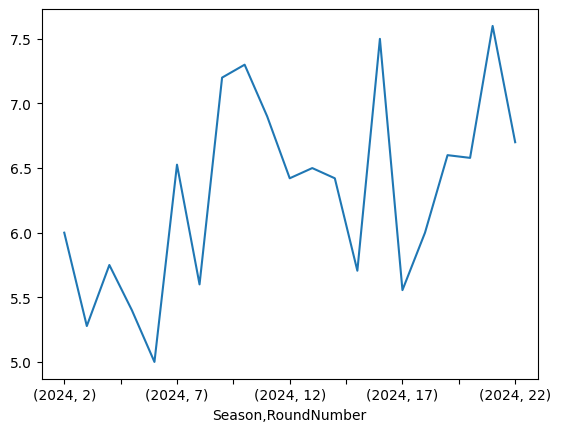

In [1326]:
all_data.groupby(["Season", "RoundNumber"]).apply(lambda x: MAE(x["QualiPosition"], x["PredictedQualiPosition"])).plot()

<Axes: xlabel='Season,RoundNumber'>

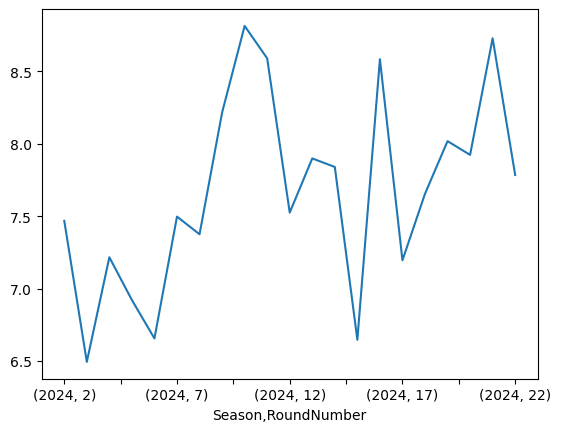

In [1327]:
all_data.groupby(["Season", "RoundNumber"]).apply(lambda x: MSE(x["QualiPosition"], x["PredictedQualiPosition"])**0.5).plot()

In [1328]:
model_stats.sort_values('MAE').head(20)

,Season,RoundNumber,r2_score,MAE,FP3Delta,Prev5QualiDeltas,FP2Delta,PrevQualiDelta,TeamFP3Delta,TeamPrevQualiDelta
4,2024,6,0.591951,5.000000,1.689485,0.000000e+00,0.000000,3.297139,0.000000,0.0
1,2024,3,0.687600,5.277778,0.900338,1.088704e-14,0.097261,5.199193,0.000000,0.0
3,2024,5,0.606002,5.400000,0.655245,7.774199e-01,0.000000,3.626192,0.000000,0.0
15,2024,17,0.412023,5.555556,0.444841,2.054433e+00,0.073666,1.166880,0.000000,0.0
6,2024,8,0.561852,5.600000,1.670546,7.218305e-01,0.000000,2.521450,0.000000,0.0
13,2024,15,0.411085,5.705882,0.696857,1.732730e+00,0.000000,1.317526,0.000000,0.0
2,2024,4,0.656328,5.750000,1.252276,0.000000e+00,0.000000,4.453067,0.000000,0.0
0,2024,2,0.685268,6.000000,6.530257,0.000000e+00,0.292420,0.000000,0.000000,0.0
16,2024,18,0.404430,6.000000,0.525519,1.608835e+00,0.187056,1.359745,0.000000,0.0
10,2024,12,0.529110,6.421053,2.100758,8.766761e-01,0.000000,1.700134,0.003746,0.0


In [1329]:
model_stats["MAE"].mean()

np.float64(6.311265909872721)

<Axes: >

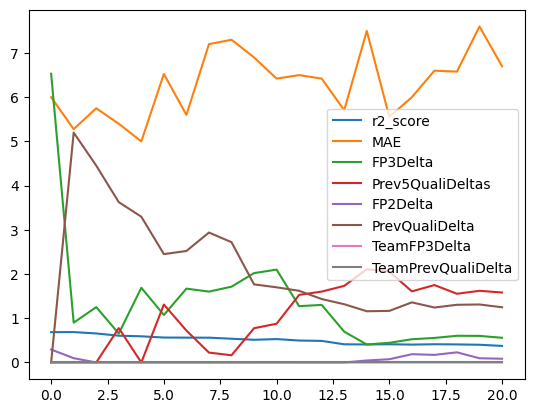

In [1330]:
model_stats.loc[:, (model_stats.columns != 'Season') & (model_stats.columns != 'RoundNumber')].plot()

In [1312]:
# Compute MAE per event
mae_per_event = all_data.groupby(['Season', 'RoundNumber']).apply(
    lambda df: MAE(df['QualiPosition'], df['PredictedQualiPosition'])
).reset_index(name='MAE')

mae_per_event = mae_per_event.sort_values('MAE')
print(mae_per_event)

# Global MAE across all predictions
global_mae = MAE(all_data['QualiPosition'], all_data['PredictedQualiPosition'])
print(f"Global MAE: {global_mae:.3f}")

# Preview predictions
print(all_data[['QualiPosition', 'PredictedQualiPosition']].head())

    Season  RoundNumber       MAE
4     2024            6  5.000000
1     2024            3  5.277778
3     2024            5  5.400000
15    2024           17  5.555556
6     2024            8  5.600000
13    2024           15  5.705882
2     2024            4  5.750000
0     2024            2  6.000000
16    2024           18  6.000000
10    2024           12  6.421053
12    2024           14  6.421053
11    2024           13  6.500000
5     2024            7  6.526316
18    2024           20  6.578947
17    2024           19  6.600000
20    2024           22  6.700000
9     2024           11  6.900000
7     2024            9  7.200000
8     2024           10  7.300000
14    2024           16  7.500000
19    2024           21  7.600000
Global MAE: 6.336
                                 QualiPosition  PredictedQualiPosition
Season RoundNumber DriverNumber                                       
2024   2           1                       1.0                       1
                   10

# A visualization of deltas throughout a season
This is shown to make sure at atleast one driver has a quali delta of 0 every race and to analyse outlier races which have many Deltas that have been capped to 4

<Axes: xlabel='RoundNumber', ylabel='QualiDelta'>

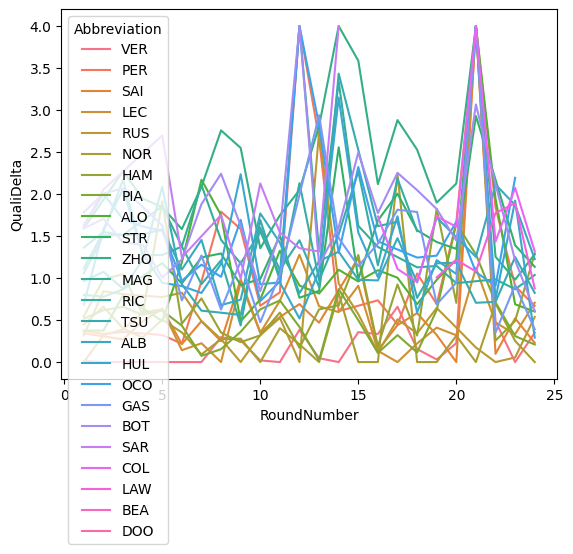

In [1242]:
subset = results.loc[results.index.get_level_values('Season') == 2024]
sns.lineplot(
    x=subset.index.get_level_values('RoundNumber'),
    y=subset['QualiDelta'],
    hue=subset['Abbreviation'],
    errorbar=None
)


In [1274]:
corr = results['TeamFP3Delta'].corr(results['FP3Delta'])
print(corr)

0.9326347174000844


# Correlations between features
I have plotted the correlations between the quali delta and all of my features to make sure they are all relevant to my prediction.

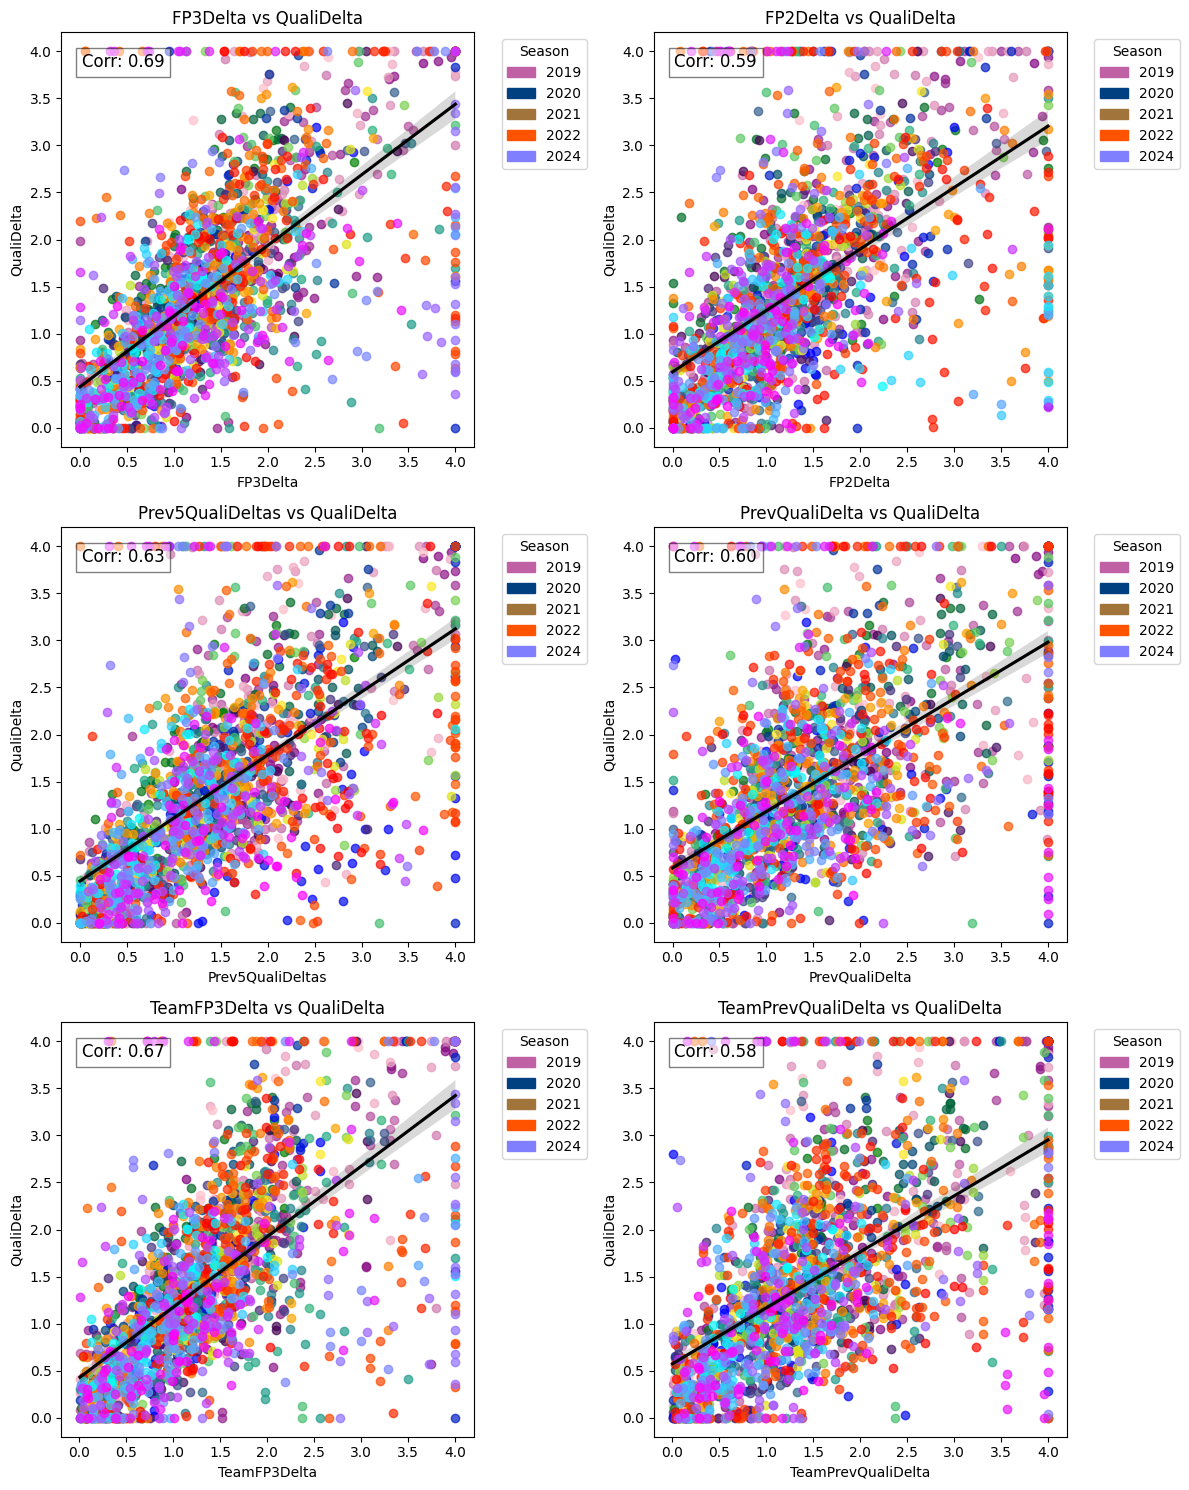

In [1275]:
results = results.reset_index()
results = results.drop_duplicates(subset=['Season', 'RoundNumber', 'DriverNumber']).set_index(['Season', 'RoundNumber', 'DriverNumber'])

# Define custom colormaps for specific seasons
season_cmaps = {
    2019: LinearSegmentedColormap.from_list("purple_pink", ["purple", "pink"]),
    2020: LinearSegmentedColormap.from_list("green_blue", ["green", "blue"]),
    2022: LinearSegmentedColormap.from_list("orange_red", ["orange", "red"]),
    2024: LinearSegmentedColormap.from_list("cyan_magenta", ["cyan", "magenta"]),
}

# Prepare plots
fig, axes = plt.subplots(3, 2, figsize=(12, 15))
plots_info = [
    ('FP3Delta', axes[0, 0], 'FP3Delta vs QualiDelta'),
    ('FP2Delta', axes[0, 1], 'FP2Delta vs QualiDelta'),
    ('Prev5QualiDeltas', axes[1, 0], 'Prev5QualiDeltas vs QualiDelta'),
    ('PrevQualiDelta', axes[1, 1], 'PrevQualiDelta vs QualiDelta'),
    ('TeamFP3Delta', axes[2, 0], 'TeamFP3Delta vs QualiDelta'),
    ('TeamPrevQualiDelta', axes[2, 1], 'TeamPrevQualiDelta vs QualiDelta')
]

# Extract unique seasons from index level
sorted_seasons = sorted(results.index.get_level_values('Season').unique())

for x_col, ax, title in plots_info:
    for season in sorted_seasons:
        # Select data for one season
        season_data = results.loc[season]

        # Get unique rounds for this season
        unique_rounds = sorted(season_data.index.get_level_values('RoundNumber').unique())
        cmap = season_cmaps.get(season, plt.cm.viridis)
        colors = cmap(np.linspace(0, 1, len(unique_rounds)))
        round_color_mapping = {round_num: color for round_num, color in zip(unique_rounds, colors)}

        # Plot each round
        for round_num in unique_rounds:
            subset = season_data.loc[round_num]
            ax.scatter(subset[x_col], subset['QualiDelta'],
                       color=round_color_mapping[round_num],
                       alpha=0.7)

    # Regression line (works fine with MultiIndex)
    sns.regplot(
        x=results[x_col],
        y=results['QualiDelta'],
        ax=ax,
        scatter=False,
        color='black'
    )

    # Correlation text
    corr = results[x_col].corr(results['QualiDelta'])
    ax.set_title(title)
    ax.text(0.05, 0.95, f'Corr: {corr:.2f}', transform=ax.transAxes,
            verticalalignment='top', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

    # Custom legend: only one patch per season
    season_patches = []
    for season in sorted_seasons:
        cmap = season_cmaps.get(season, plt.cm.viridis)
        color_start = to_rgba(cmap(0.0))
        color_end = to_rgba(cmap(1.0))
        mid_color = tuple(np.mean([color_start[:3], color_end[:3]], axis=0))
        season_patches.append(mpatches.Patch(color=mid_color, label=str(season)))

    ax.legend(handles=season_patches, title="Season",
              bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()

## Inter Feature correlation
TODO explain how highly correlated features are a problem

<Axes: >

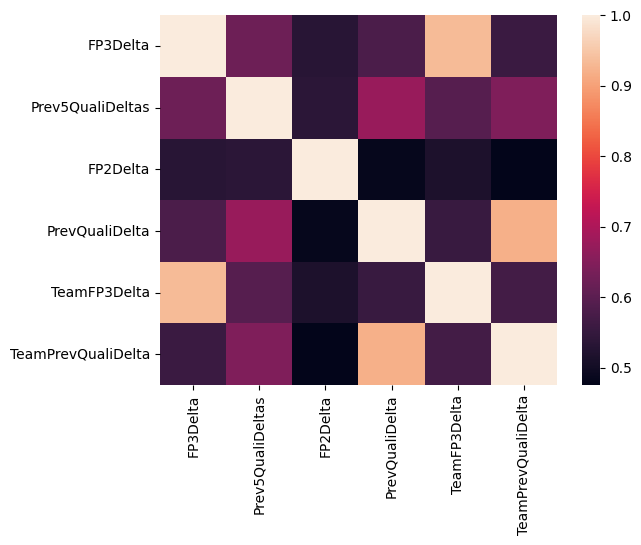

In [1276]:
# calculate the correlation matrix on the numeric columns
corr = results[['FP3Delta', 'Prev5QualiDeltas', 'FP2Delta', 'PrevQualiDelta', 'TeamFP3Delta', 'TeamPrevQualiDelta']].select_dtypes('number').corr()

# plot the heatmap
sns.heatmap(corr)

# Cutting the data
## Track Temperature
By cutting my data by track temperature we can see that as temperature decreases the correlation between the FP3 Delta and the Qualifying Delta also decreases. This is because when the track is very cold in Qualifying it means there is a high different between the track temperature in FP3 and Qualifying causing the correlation to be lower. Because i want to keep the model generalized so i can work with any data and wont have to have poorer results for rookies or stand in drivers.

If i was to use driver profiles, the way i would do it is to take the 

/tmp/ipykernel_22112/1396686068.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  results.groupby('Quali_TrackTempBin')[['QualiDelta', 'FP3Delta']]


Quali_TrackTempBin            
Cool (<24°C)        QualiDelta    0.464804
Mild (24-30°C)      QualiDelta    0.664923
Medium (30-36°C)    QualiDelta    0.758267
Warm (36-42°C)      QualiDelta    0.783473
Hot (>44°C)         QualiDelta    0.814678
Name: FP3Delta, dtype: float64


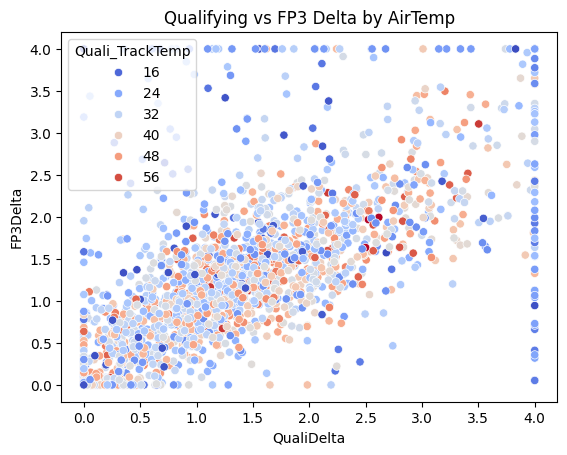

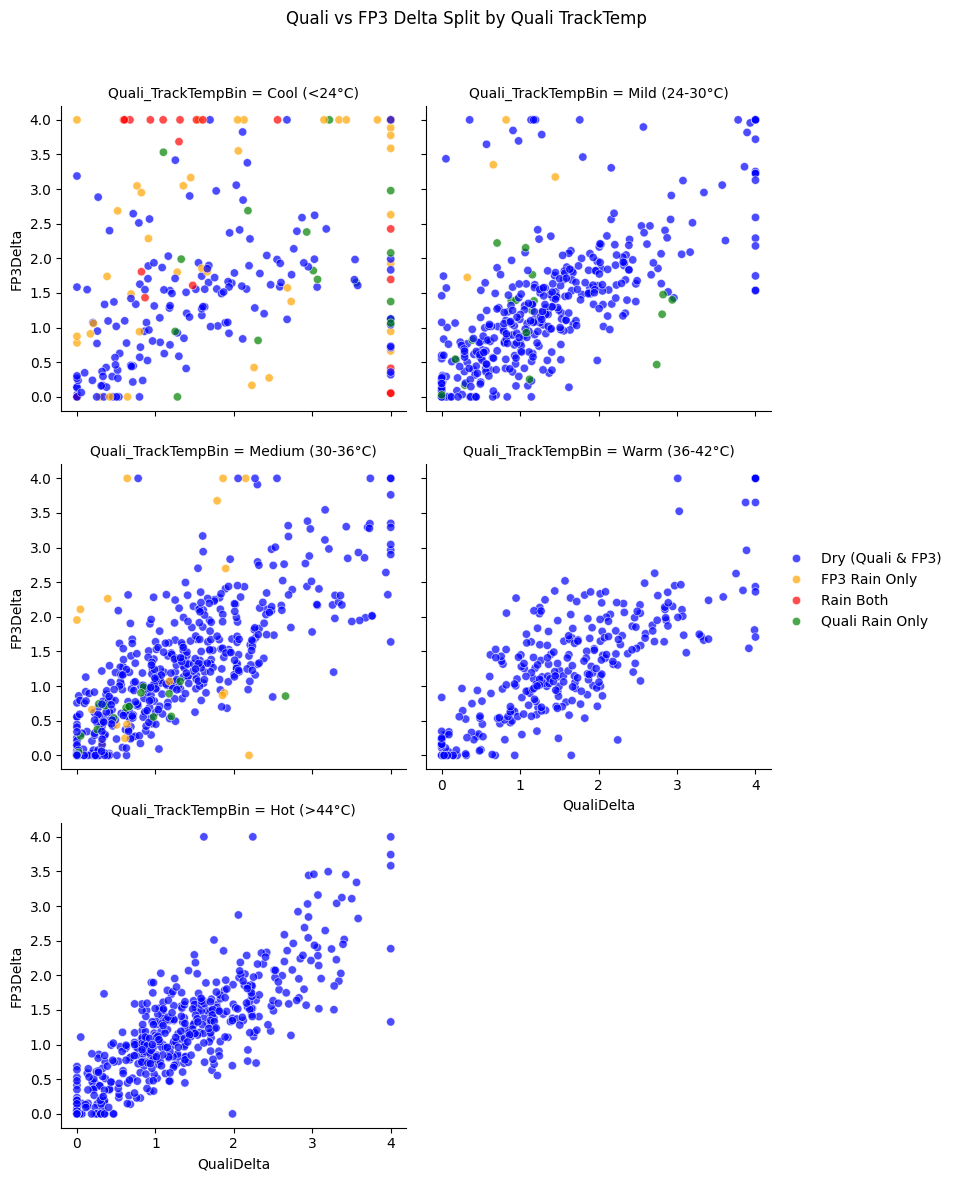

In [1277]:
results['Quali_TrackTempBin'] = pd.cut(
    results['Quali_TrackTemp'],
    bins=[-float('inf'), 24, 30, 36, 42, float('inf')],
    labels=['Cool (<24°C)', 'Mild (24-30°C)', 'Medium (30-36°C)', 'Warm (36-42°C)', 'Hot (>44°C)']
)
# Binary columns for rain

# Combine into one categorical column
def rain_category(row):
    if not row['Quali_Rainfall'] and not row['FP3_Rainfall']:
        return 'Dry (Quali & FP3)'
    elif not row['Quali_Rainfall'] and row['FP3_Rainfall']:
        return 'FP3 Rain Only'
    elif row['Quali_Rainfall'] and not row['FP3_Rainfall']:
        return 'Quali Rain Only'
    else:
        return 'Rain Both'

results['RainCategory'] = results.apply(rain_category, axis=1)

corrs = (
    results.groupby('Quali_TrackTempBin')[['QualiDelta', 'FP3Delta']]
    .corr()
    .iloc[0::2, -1]  # extract correlation between the two variables
)
print(corrs)


sns.scatterplot(
    data=results,
    x='QualiDelta',
    y='FP3Delta',
    hue='Quali_TrackTemp',
    palette='coolwarm'
)
plt.title("Qualifying vs FP3 Delta by AirTemp")

palette = {
    'Dry (Quali & FP3)': 'blue',
    'FP3 Rain Only': 'orange',
    'Quali Rain Only': 'green',
    'Rain Both': 'red'
}

g = sns.FacetGrid(results, col='Quali_TrackTempBin', col_wrap=2, height=4)
g.map_dataframe(
    sns.scatterplot,
    x='QualiDelta',
    y='FP3Delta',
    hue='RainCategory',
    palette=palette,
    alpha=0.7
)
g.add_legend()
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Quali vs FP3 Delta Split by Quali TrackTemp")
plt.show()


plt.show()


In [1278]:
X = results[['FP3Delta', 'Prev5QualiDeltas', 'FP2Delta', 'PrevQualiDelta', 
                 'TeamFP3Delta', 'TeamPrevQualiDelta', 'Pace']]
y = results['QualiDelta']
print(len(X))
print(len(y))

1946
1946


In [1280]:
# groups = results.index.get_level_values('RoundNumber')  # This ensures all rows of the same race stay together

# # Define the splitter
# gss = GroupShuffleSplit(n_splits=2, test_size=0.2, random_state=2)

# # Perform the split
# train_idx, test_idx = next(gss.split(X, y, groups=groups))
# X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
# y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
# Split by chronological order instead of random
# Define feature and target columns

# Define train/test split by season
train_mask = results.index.get_level_values('Season') < 2024
test_mask = results.index.get_level_values('Season') == 2024

# Apply masks
X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]



In [1365]:
X_train

FP3Delta  Prev5QualiDeltas  FP2Delta  \
Season RoundNumber DriverNumber                                         
2019   1           77               1.130            1.1300     0.048   
                   44               0.000            0.0000     0.000   
                   33               1.189            1.1890     0.800   
                   5                0.264            0.2640     0.873   
                   16               0.457            0.4570     1.154   
...                                   ...               ...       ...   
2022   22          47               1.491            2.8558     1.693   
                   20               1.374            2.3214     1.769   
                   44               0.240            0.6548     0.615   
                   6                1.664            3.8066     2.116   
                   14               1.094            1.1912     0.897   

                                 PrevQualiDelta  TeamFP3Delta  \
Season RoundNumber DriverNumber                                 
2019   1           77                     1.130        0.5650   
                   44                     0.000        0.5650   
                   33                     1.189        1.1320   
                   5                      0.264        0.3605   
                   16                     0.457        0.3605   
...                                         ...           ...   
2022   22          47                     4.000        1.4325   
                   20                     0.529        1.4325   
                   44                     0.658        0.3265   
                   6                      4.000        1.3665   
                   14                     0.513        1.0925   

                                 TeamPrevQualiDelta      Pace  
Season RoundNumber DriverNumber                                
2019   1           77                        0.5650  0.559339  
                   44                        0.5650  0.673175  
                   33                        1.1320  0.536958  
                   5                         0.3605  0.325465  
                   16                        0.3605  0.998751  
...                                             ...       ...  
2022   22          47                        3.0045  0.258955  
                   20                        3.0045  0.332805  
                   44                        0.5475  0.592918  
                   6                         2.4820  0.140985  
                   14                        0.6095  0.549031  

[1487 rows x 7 columns]

<Axes: xlabel='Pace', ylabel='QualiDelta'>

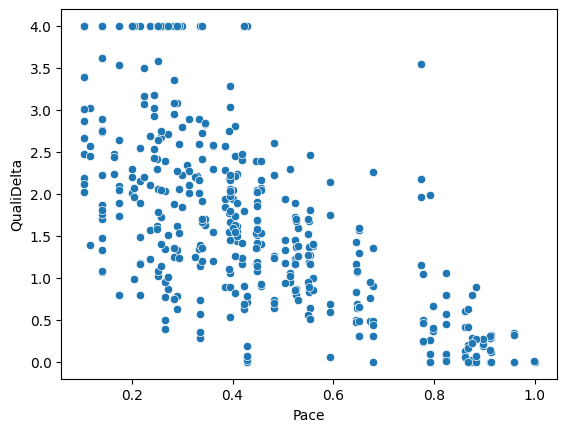

In [1369]:


sns.scatterplot(data=X_train.iloc[X_train.index.get_level_values("Season")==2022].join(y_train)[["Pace", "QualiDelta"]], x="Pace", y="QualiDelta")

In [1353]:
lr = Lasso(alpha=0.025).fit(X_train, y_train)
lr_y_pred = lr.predict(X_test)

rf = RandomForestRegressor()
rf.fit(X_train, y_train)
rf_y_pred = rf.predict(X_test)

# lr = LinearRegression()
# lr.fit(X, y)
# lr_y_pred = lr.predict(X)

# rf = RandomForestRegressor()
# rf.fit(X, y)
# rf_y_pred = rf.predict(X)
lr.coef_

array([ 0.28729823,  0.14096829,  0.24510886,  0.08864151,  0.16656646,
        0.07498458, -0.        ])

In [1352]:
X_train

FP3Delta  Prev5QualiDeltas  FP2Delta  \
Season RoundNumber DriverNumber                                         
2019   1           77               1.130            1.1300     0.048   
                   44               0.000            0.0000     0.000   
                   33               1.189            1.1890     0.800   
                   5                0.264            0.2640     0.873   
                   16               0.457            0.4570     1.154   
...                                   ...               ...       ...   
2022   22          47               1.491            2.8558     1.693   
                   20               1.374            2.3214     1.769   
                   44               0.240            0.6548     0.615   
                   6                1.664            3.8066     2.116   
                   14               1.094            1.1912     0.897   

                                 PrevQualiDelta  TeamFP3Delta  \
Season RoundNumber DriverNumber                                 
2019   1           77                     1.130        0.5650   
                   44                     0.000        0.5650   
                   33                     1.189        1.1320   
                   5                      0.264        0.3605   
                   16                     0.457        0.3605   
...                                         ...           ...   
2022   22          47                     4.000        1.4325   
                   20                     0.529        1.4325   
                   44                     0.658        0.3265   
                   6                      4.000        1.3665   
                   14                     0.513        1.0925   

                                 TeamPrevQualiDelta      Pace  
Season RoundNumber DriverNumber                                
2019   1           77                        0.5650  0.559339  
                   44                        0.5650  0.673175  
                   33                        1.1320  0.536958  
                   5                         0.3605  0.325465  
                   16                        0.3605  0.998751  
...                                             ...       ...  
2022   22          47                        3.0045  0.258955  
                   20                        3.0045  0.332805  
                   44                        0.5475  0.592918  
                   6                         2.4820  0.140985  
                   14                        0.6095  0.549031  

[1487 rows x 7 columns]

In [1333]:
xx = X_test.copy().drop(columns=x_cols)
y_pred = [(a + b) / 2 for a, b in zip(lr_y_pred, rf_y_pred)]
xx["prediction"] = y_pred
print(xx['prediction'])
xx.reset_index()
results

# xx = X.copy().drop(columns=x_cols)
# y_pred = [(a + b) / 2 for a, b in zip(lr_y_pred, rf_y_pred)]
# xx["prediction"] = y_pred
# print(xx['prediction'])
# xx.reset_index()
# results
xx

Season  RoundNumber  DriverNumber
2024    1            1               0.958709
                     11              0.987424
                     55              0.900754
                     16              0.988989
                     63              0.897434
                                       ...   
        24           20              1.216019
                     30              1.436554
                     77              1.273114
                     43              1.621554
                     11              1.236964
Name: prediction, Length: 459, dtype: float64


Pace  prediction
Season RoundNumber DriverNumber                      
2024   1           1             0.912561    0.958709
                   11            0.797519    0.987424
                   55            0.860385    0.900754
                   16            0.998751    0.988989
                   63            0.646699    0.897434
...                                   ...         ...
       24          20            0.392311    1.216019
                   30            0.546755    1.436554
                   77            0.456257    1.273114
                   43            0.546755    1.621554
                   11            0.778489    1.236964

[459 rows x 2 columns]

In [1284]:
# create predicted delta column
results = pd.merge(results, xx['prediction'], on=['RoundNumber', 'DriverNumber', 'Season'])
# create rank of predicted delta
# score actual qualifying position vs predicted qualifying position
results

Abbreviation         TeamName TeamColor  \
RoundNumber DriverNumber Season                                           
1           1            2024            VER  Red Bull Racing    3671c6   
            11           2024            PER  Red Bull Racing    3671c6   
            55           2024            SAI          Ferrari    e8002d   
            16           2024            LEC          Ferrari    e8002d   
            63           2024            RUS         Mercedes    27f4d2   
...                                      ...              ...       ...   
24          20           2024            MAG     Haas F1 Team    B6BABD   
            30           2024            LAW               RB    6692FF   
            77           2024            BOT      Kick Sauber    52e252   
            43           2024            COL         Williams    64C4FF   
            11           2024            PER  Red Bull Racing    3671C6   

                                   TeamId          FullName CountryCode  \
RoundNumber DriverNumber Season                                           
1           1            2024    red_bull    Max Verstappen         NED   
            11           2024    red_bull      Sergio Perez         MEX   
            55           2024     ferrari      Carlos Sainz         ESP   
            16           2024     ferrari   Charles Leclerc         MON   
            63           2024    mercedes    George Russell         GBR   
...                                   ...               ...         ...   
24          20           2024        haas   Kevin Magnussen         DEN   
            30           2024          rb       Liam Lawson         NZL   
            77           2024      sauber   Valtteri Bottas         FIN   
            43           2024    williams  Franco Colapinto         ARG   
            11           2024    red_bull      Sergio Perez         MEX   

                                 Position ClassifiedPosition  GridPosition  \
RoundNumber DriverNumber Season                                              
1           1            2024         1.0                  1           1.0   
            11           2024         2.0                  2           5.0   
            55           2024         3.0                  3           4.0   
            16           2024         4.0                  4           2.0   
            63           2024         5.0                  5           3.0   
...                                   ...                ...           ...   
24          20           2024        16.0                 16          14.0   
            30           2024        17.0                 17          12.0   
            77           2024        18.0                  R           9.0   
            43           2024        19.0                  R          20.0   
            11           2024        20.0                  R          10.0   

                                                  Time    Status  Points  \
RoundNumber DriverNumber Season                                            
1           1            2024   0 days 01:31:44.742000  Finished    26.0   
            11           2024   0 days 00:00:22.457000  Finished    18.0   
            55           2024   0 days 00:00:25.110000  Finished    15.0   
            16           2024   0 days 00:00:39.669000  Finished    12.0   
            63           2024   0 days 00:00:46.788000  Finished    10.0   
...                                                ...       ...     ...   
24          20           2024   0 days 00:01:17.597000    Lapped     0.0   
            30           2024                      NaT  Finished     0.0   
            77           2024                      NaT   Retired     0.0   
            43           2024                      NaT   Retired     0.0   
            11           2024                      NaT   Retired     0.0   

                                 Laps               Country  \
RoundNumber D

In [1285]:
results.dropna(subset=['QualiPosition'], inplace=True)
results.reset_index(inplace=True)
results['PredictionRank'] = results.groupby(['RoundNumber', 'Season'])['prediction'].rank('min')
results['PredictionRank']
results = results.set_index(['Season', 'RoundNumber', 'DriverNumber']).sort_index()


# RMSE per Position

    Rank Cutoff       MAE
0             1  1.521739
1             2  2.304348
2             3  2.750000
3             4  2.875000
4             5  2.136364
5             6  3.083333
6             7  3.375000
7             8  3.391304
8             9  3.272727
9            10  2.960000
10           11  4.136364
11           12  3.000000
12           13  2.583333
13           14  2.840000
14           15  2.653846
15           16  3.869565
16           17  4.478261
17           18  4.347826
18           19  3.800000
19           20  1.529412


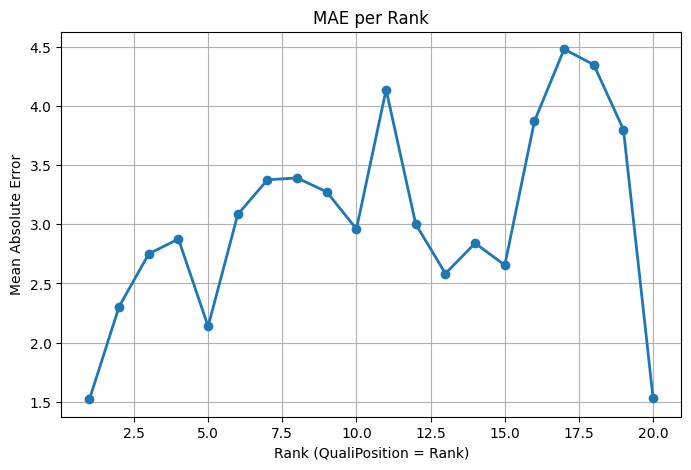

In [1286]:
mae_values = []

for rank in range(1, 21):
    results_top_rank = results[results['QualiPosition'] == rank]
    
    # Compute global RMSE for this rank
    global_mae = MAE(results_top_rank['QualiPosition'], results_top_rank['PredictionRank'])
    mae_values.append(global_mae)

# Create a DataFrame for plotting
mae_df = pd.DataFrame({
    'Rank Cutoff': range(1, 21),
    'MAE': mae_values
})
print(mae_df)
# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(mae_df['Rank Cutoff'], mae_df['MAE'], marker='o', linestyle='-', linewidth=2)
plt.title('MAE per Rank')
plt.xlabel('Rank (QualiPosition = Rank)')
plt.ylabel('Mean Absolute Error')
plt.grid(True)
plt.show()
# pred = results_top_rank[['QualiPosition', 'PredictionRank']]
# rmse = MSE(results_top_rank['QualiPosition'], results_top_rank['PredictionRank'])
# print(rmse)
# pred.head()

## MAE per Driver


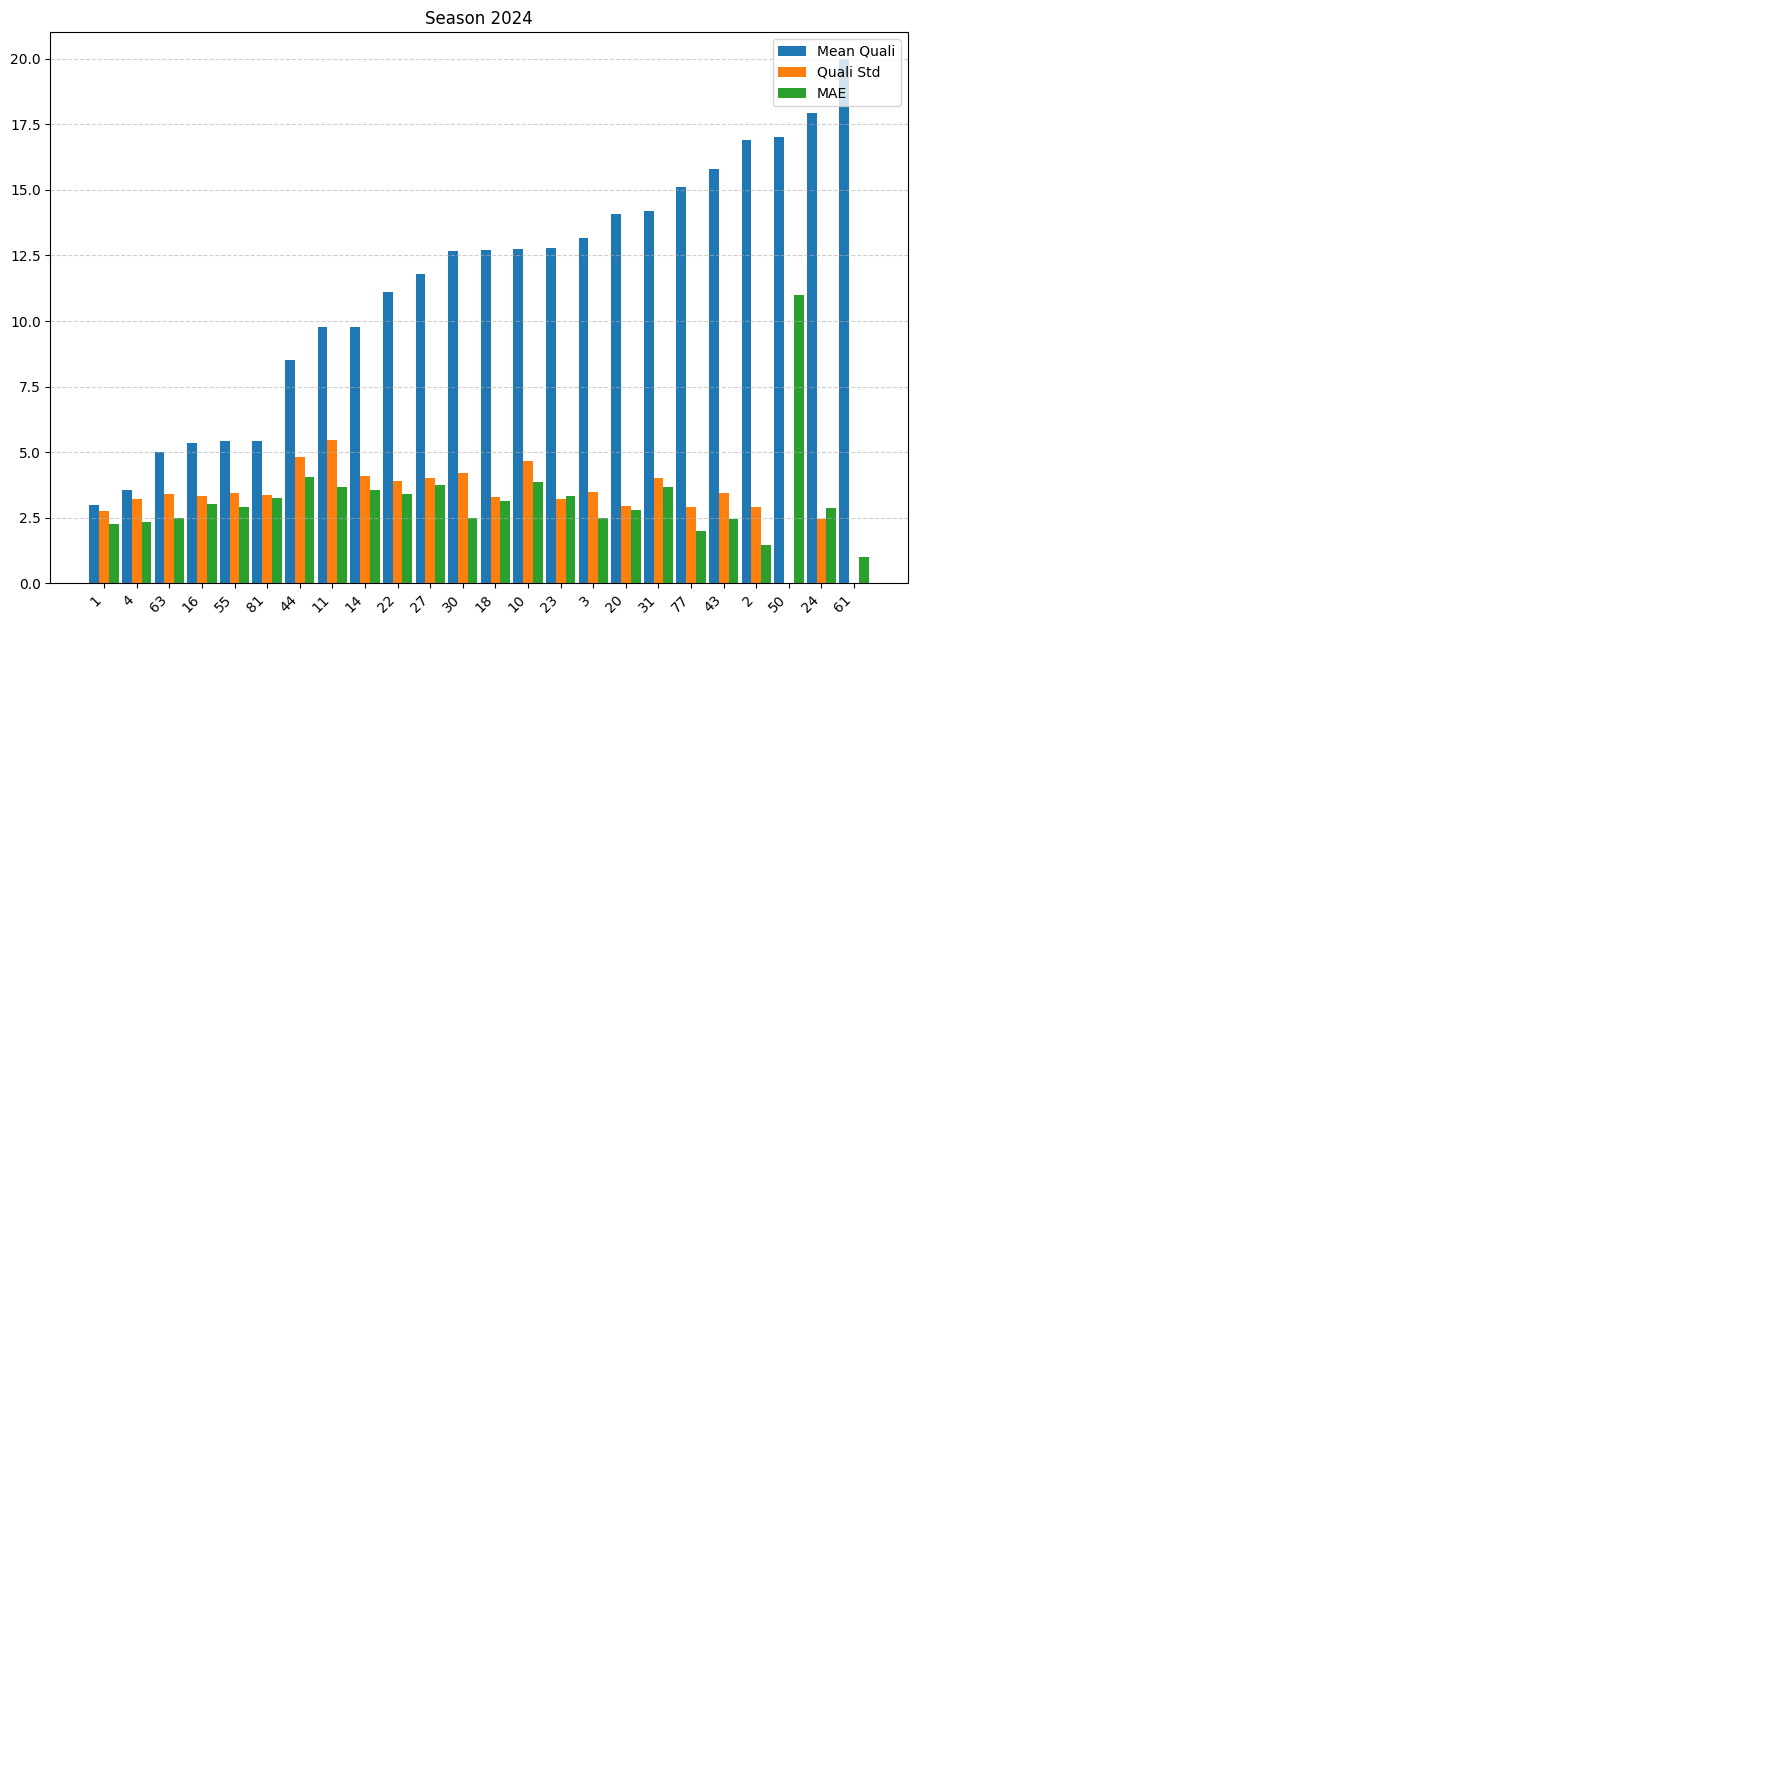

In [1287]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error as MAE
import numpy as np

# Loop through each season using the MultiIndex level
seasons = results.index.get_level_values('Season').unique()

fig, axes = plt.subplots(3, 2, figsize=(18, 18))
axes = axes.flatten()

for i, season in enumerate(seasons):
    ax = axes[i]

    # Filter by the index level
    season_data = results.loc[season]
    
    # Now season_data has 2 index levels: RoundNumber, DriverNumber
    unique_drivers = season_data.index.get_level_values('DriverNumber').unique()

    mae_vals = []
    mean_quali = []
    std_quali = []

    for driver in unique_drivers:
        driver_data = season_data[season_data.index.get_level_values('DriverNumber') == driver]

        y_true = driver_data['QualiPosition'].astype(float)
        y_pred = driver_data['PredictionRank'].astype(float)

        mae_vals.append(MAE(y_true, y_pred))
        mean_quali.append(y_true.mean())
        std_quali.append(y_true.std())

    df = pd.DataFrame({
        'DriverNumber': unique_drivers,
        'MAE': mae_vals,
        'MeanQuali': mean_quali,
        'StdQuali': std_quali
    }).sort_values('MeanQuali').reset_index(drop=True)

    x = np.arange(len(df))
    width = 0.3

    ax.bar(x - width, df['MeanQuali'], width, label="Mean Quali")
    ax.bar(x, df['StdQuali'], width, label="Quali Std")
    ax.bar(x + width, df['MAE'], width, label="MAE")

    ax.set_title(f"Season {season}")
    ax.set_xticks(x)
    ax.set_xticklabels(df['DriverNumber'], rotation=45, ha='right')
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    ax.legend(loc='upper right')

# Hide unused subplots
for j in range(len(seasons), 6):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [1288]:
print('% that are the correct position exactly')
print(len(results[results['PredictionRank'] == results['QualiPosition']])/len(results))

% that are the correct position exactly
0.15468409586056645


In [1289]:
rmse = MAE(results['QualiPosition'], results['PredictionRank'])
print(rmse)
pred = results[['QualiPosition', 'PredictionRank']]
pred

3.054466230936819


QualiPosition  PredictionRank
Season RoundNumber DriverNumber                               
2024   1           1                       1.0             4.0
                   10                     20.0            20.0
                   11                      5.0             7.0
                   14                      6.0             1.0
                   16                      2.0             6.0
...                                        ...             ...
       24          55                      3.0             6.0
                   61                     20.0            19.0
                   63                      7.0             3.0
                   77                      9.0            11.0
                   81                      2.0             2.0

[459 rows x 2 columns]

In [1290]:
# Compute RMSE per event (replace 'Event' with your actual column name)
rmse_per_event = results.groupby(['RoundNumber', 'Season']).apply(
    lambda df: MAE(df['QualiPosition'], df['PredictionRank'])
).reset_index(name='RMSE')
rmse_per_event= rmse_per_event.sort_values('RMSE')
print(rmse_per_event)

# Optional: if you still want the global RMSE across all data
global_rmse = MAE(results['QualiPosition'], results['PredictionRank'])
print(f"Global RMSE: {global_rmse:.3f}")

# Preview just the prediction columns
pred = results[['QualiPosition', 'PredictionRank']]
pred.head()

    RoundNumber  Season      RMSE
9            10    2024  1.700000
0             1    2024  1.800000
1             2    2024  2.222222
15           16    2024  2.300000
17           18    2024  2.300000
2             3    2024  2.500000
10           11    2024  2.500000
6             7    2024  2.631579
16           17    2024  2.666667
5             6    2024  2.700000
12           13    2024  2.700000
18           19    2024  2.900000
22           23    2024  3.000000
7             8    2024  3.000000
19           20    2024  3.210526
4             5    2024  3.300000
11           12    2024  3.368421
14           15    2024  3.588235
21           22    2024  3.600000
13           14    2024  3.789474
8             9    2024  3.900000
23           24    2024  4.100000
3             4    2024  4.416667
20           21    2024  5.600000
Global RMSE: 3.054


QualiPosition  PredictionRank
Season RoundNumber DriverNumber                               
2024   1           1                       1.0             4.0
                   10                     20.0            20.0
                   11                      5.0             7.0
                   14                      6.0             1.0
                   16                      2.0             6.0

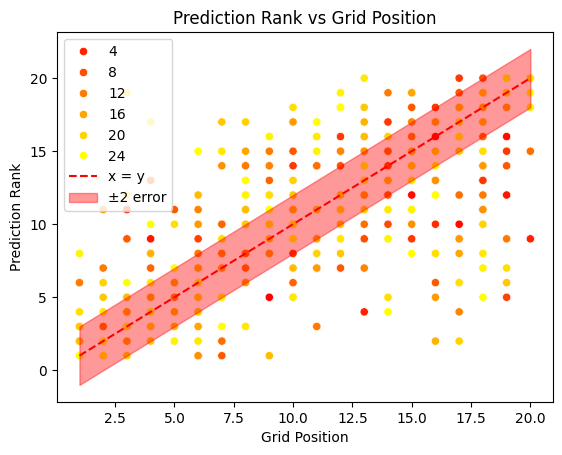

54.68% of predictions are within ±2 of x = y


In [1291]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Scatter plot
ytor = LinearSegmentedColormap.from_list("red_yellow", ["red", "yellow"])
sns.scatterplot(x=results['QualiPosition'], y=results['PredictionRank'], hue=results.index.get_level_values('RoundNumber'), palette=ytor)

# Define x values
x_vals = np.linspace(results['QualiPosition'].min(), results['QualiPosition'].max(), 100)

# Plot y = x line
plt.plot(x_vals, x_vals, color='red', linestyle='--', label='x = y')

# Add ±2 error area
plt.fill_between(x_vals, x_vals - 2, x_vals + 2, color='red', alpha=0.4, label='±2 error')

plt.xlabel('Grid Position')
plt.ylabel('Prediction Rank')
plt.title('Prediction Rank vs Grid Position')
plt.legend()
plt.show()

# Count points inside ±2 of y=x
inside_error = ((results['PredictionRank'] >= results['QualiPosition'] - 2) &
                (results['PredictionRank'] <= results['QualiPosition'] + 2))

percentage_inside = inside_error.mean() * 100  # mean() gives fraction of True values
print(f"{percentage_inside:.2f}% of predictions are within ±2 of x = y")



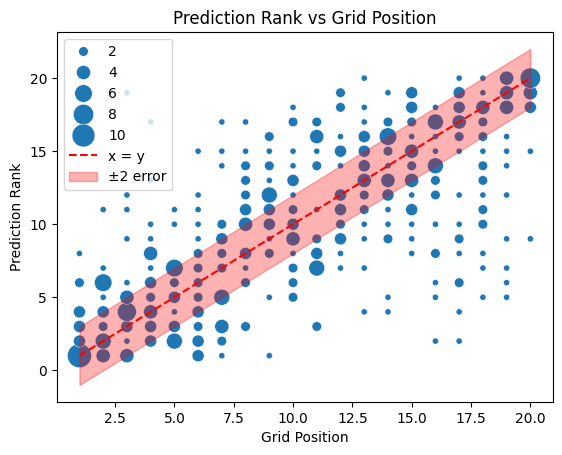

54.68% of predictions are within ±2 of x = y


In [1292]:
df = results.reset_index()

# Group by coordinate pairs and count occurrences
counts = (
    df.groupby(['QualiPosition', 'PredictionRank'], as_index=False)
      .agg(Count=('RoundNumber', 'size'),
           Season=('Season', 'first'))
)

# Scatter plot with point size representing count
sns.scatterplot(
    data=counts,
    x='QualiPosition',
    y='PredictionRank',
    size='Count',
    sizes=(20, 300),
    legend=True
)

# Add reference line y = x
x_vals = np.linspace(df['QualiPosition'].min(), df['QualiPosition'].max(), 100)
plt.plot(x_vals, x_vals, color='red', linestyle='--', label='x = y')

# Add ±2 error band
plt.fill_between(x_vals, x_vals - 2, x_vals + 2, color='red', alpha=0.3, label='±2 error')

plt.xlabel('Grid Position')
plt.ylabel('Prediction Rank')
plt.title('Prediction Rank vs Grid Position')
plt.legend()
plt.show()

# Compute % of predictions within ±2 of y = x
inside_error = (
    (df['PredictionRank'] >= df['QualiPosition'] - 2) &
    (df['PredictionRank'] <= df['QualiPosition'] + 2)
)
percentage_inside = inside_error.mean() * 100

print(f"{percentage_inside:.2f}% of predictions are within ±2 of x = y")

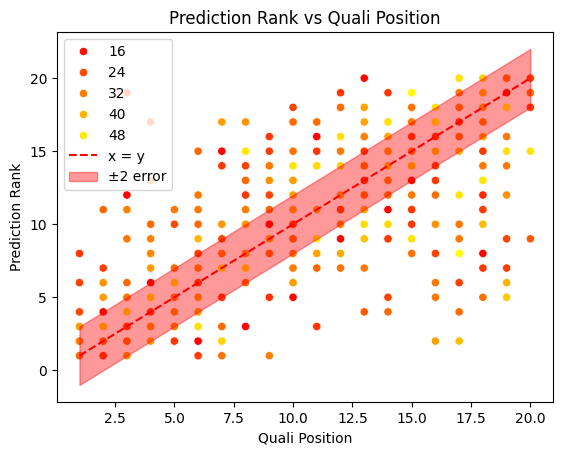

54.68% of predictions are within ±2 of x = y


In [1293]:
# Scatter plot

ytor = LinearSegmentedColormap.from_list("red_yellow", ["red", "yellow"])
sns.scatterplot(x=results['QualiPosition'], y=results['PredictionRank'], hue=results['Quali_TrackTemp'], palette=ytor)
# Define x values
x_vals = np.linspace(results['QualiPosition'].min(), results['QualiPosition'].max(), 100)

# Plot y = x line
plt.plot(x_vals, x_vals, color='red', linestyle='--', label='x = y')

# Add ±2 error area
plt.fill_between(x_vals, x_vals - 2, x_vals + 2, color='red', alpha=0.4, label='±2 error')

plt.xlabel('Quali Position')
plt.ylabel('Prediction Rank')
plt.title('Prediction Rank vs Quali Position')
plt.legend()
plt.show()

# Count points inside ±2 of y=x
inside_error = ((results['PredictionRank'] >= results['QualiPosition'] - 2) &
                (results['PredictionRank'] <= results['QualiPosition'] + 2))

percentage_inside = inside_error.mean() * 100  # mean() gives fraction of True values
print(f"{percentage_inside:.2f}% of predictions are within ±2 of x = y")



          TeamName       MAE
0      Kick Sauber  2.425532
1         Williams  2.642857
2          McLaren  2.791667
3               RB  2.936170
4  Red Bull Racing  2.955556
5          Ferrari  2.978261
6         Mercedes  3.276596
7     Aston Martin  3.347826
8     Haas F1 Team  3.478261
9           Alpine  3.711111


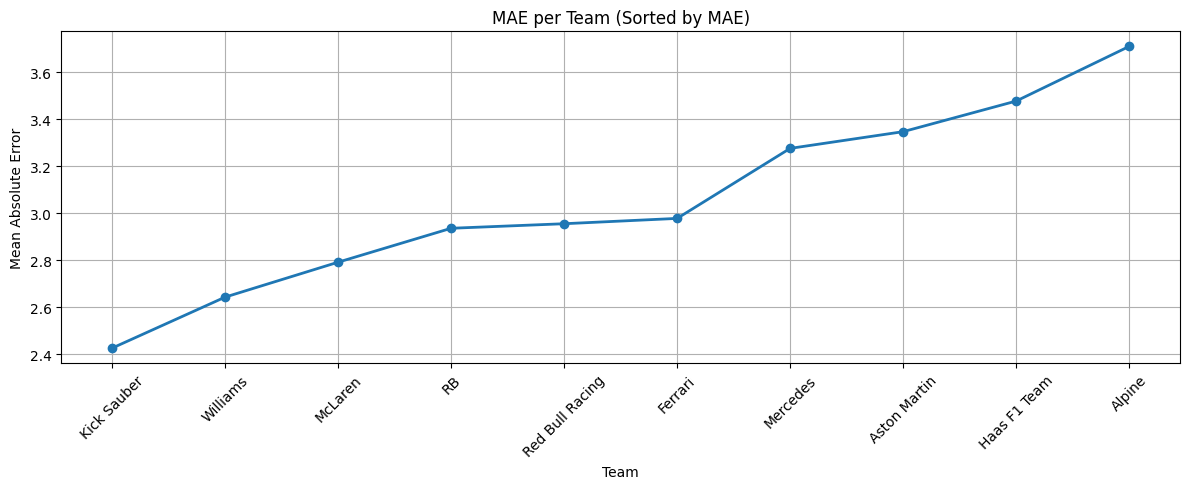

In [1294]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error as MAE

# Compute MAE per team
mae_values = []
team_ids = results['TeamName'].unique()

for team in team_ids:
    team_data = results[results['TeamName'] == team]
    global_mae = MAE(team_data['QualiPosition'], team_data['PredictionRank'])
    mae_values.append(global_mae)

# DataFrame for plotting
mae_df = pd.DataFrame({
    'TeamName': team_ids,
    'MAE': mae_values
})

# Sort by MAE ascending
mae_df = mae_df.sort_values("MAE", ascending=True).reset_index(drop=True)

print(mae_df)

# Plot the results
plt.figure(figsize=(12, 5))
plt.plot(mae_df['TeamName'], mae_df['MAE'], marker='o', linestyle='-', linewidth=2)
plt.title('MAE per Team (Sorted by MAE)')
plt.xlabel('Team')
plt.ylabel('Mean Absolute Error')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Correlation between Std Dev and MAE: 0.22815217307569202


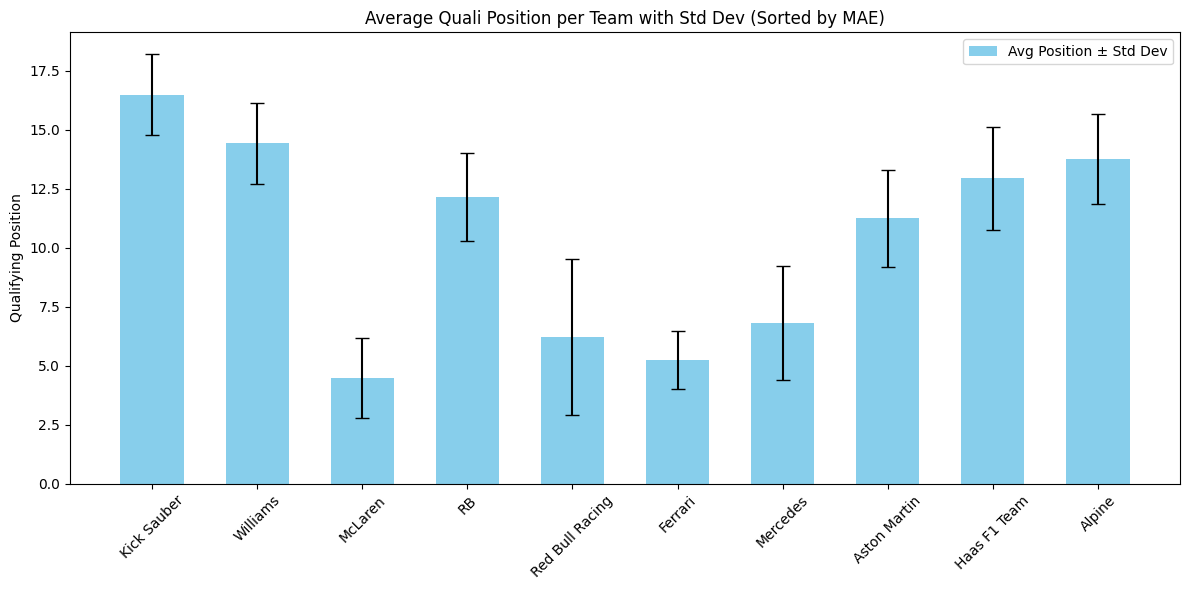

In [1295]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error as MAE  # assuming PredictionRank exists in your df

# Keep only relevant columns
df_team = df[['TeamName', 'FullName', 'QualiPosition', 'PredictionRank', 'RoundNumber']]

# Compute MAE per team
mae_values = []
team_ids = df_team['TeamName'].unique()

for team in team_ids:
    team_data = df_team[df_team['TeamName'] == team]
    mae = MAE(team_data['QualiPosition'], team_data['PredictionRank'])
    mae_values.append({'TeamName': team, 'MAE': mae})

mae_df = pd.DataFrame(mae_values)

# Pivot so each row is a race, columns are driver positions
positions_pivot = df_team.pivot_table(index=['RoundNumber', 'TeamName'], 
                                      columns='FullName', 
                                      values='QualiPosition')

# Average position per team per race
positions_pivot['AvgPosition'] = positions_pivot.mean(axis=1)

# Standard deviation per race
positions_pivot['PositionStd'] = positions_pivot.std(axis=1)

# Aggregate by team across all races
team_stats = positions_pivot.groupby('TeamName').agg({
    'AvgPosition': 'mean',
    'PositionStd': 'mean'
}).reset_index()

# Merge MAE
team_stats = team_stats.merge(mae_df, on='TeamName')

# Sort by MAE
team_stats = team_stats.sort_values('MAE', ascending=True).reset_index(drop=True)

# Plotting with error bars (y-axis not flipped)
x = np.arange(len(team_stats['TeamName']))  # label locations
width = 0.6  # width of bars

fig, ax = plt.subplots(figsize=(12,6))
ax.bar(x, team_stats['AvgPosition'], width, color='skyblue', 
       yerr=team_stats['PositionStd'], capsize=5, label='Avg Position ± Std Dev')

# Correlation between PositionStd and MAE
correlation = team_stats['PositionStd'].corr(team_stats['MAE'])
print("Correlation between Std Dev and MAE:", correlation)

# Labels and title
ax.set_ylabel('Qualifying Position')
ax.set_title('Average Quali Position per Team with Std Dev (Sorted by MAE)')
ax.set_xticks(x)
ax.set_xticklabels(team_stats['TeamName'], rotation=45)
ax.legend()
plt.tight_layout()
plt.show()


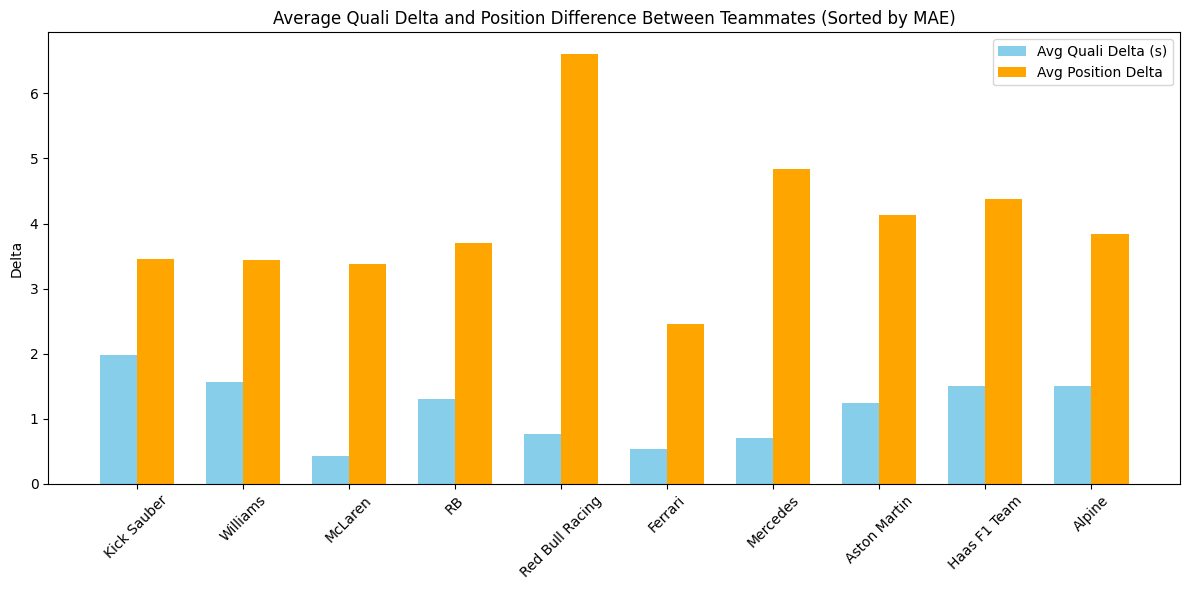

In [1296]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error as MAE  # Assuming you use sklearn's MAE

# Keep only relevant columns
df_team = df[['TeamName', 'FullName', 'QualiDelta', 'QualiPosition', 'RoundNumber', 'PredictionRank']]

# Compute MAE per team
mae_values = []
team_ids = df_team['TeamName'].unique()

for team in team_ids:
    team_data = df_team[df_team['TeamName'] == team]
    mae = MAE(team_data['QualiPosition'], team_data['PredictionRank'])  # Assuming PredictionRank exists
    mae_values.append({'TeamName': team, 'MAE': mae})

mae_df = pd.DataFrame(mae_values)

# Pivot so each row is a race, columns are driver positions
positions_pivot = df_team.pivot_table(index=['RoundNumber', 'TeamName'], 
                                      columns='FullName', 
                                      values='QualiPosition')

# Calculate position difference per race (max - min)
positions_pivot['PositionDelta'] = positions_pivot.max(axis=1) - positions_pivot.min(axis=1)

# Average position delta per team
avg_position_delta = positions_pivot.groupby('TeamName')['PositionDelta'].mean().reset_index()

# Average Quali delta per team
avg_quali_delta = df_team.groupby('TeamName')['QualiDelta'].mean().reset_index()

# Merge all metrics
team_avg_delta = avg_quali_delta.merge(avg_position_delta, on='TeamName').merge(mae_df, on='TeamName')

# Sort by MAE
team_avg_delta = team_avg_delta.sort_values('MAE', ascending=True).reset_index(drop=True)

# Plotting
x = np.arange(len(team_avg_delta['TeamName']))
width = 0.35

fig, ax = plt.subplots(figsize=(12,6))
ax.bar(x - width/2, team_avg_delta['QualiDelta'], width, label='Avg Quali Delta (s)', color='skyblue')
ax.bar(x + width/2, team_avg_delta['PositionDelta'], width, label='Avg Position Delta', color='orange')

ax.set_ylabel('Delta')
ax.set_title('Average Quali Delta and Position Difference Between Teammates (Sorted by MAE)')
ax.set_xticks(x)
ax.set_xticklabels(team_avg_delta['TeamName'], rotation=45)
ax.legend()
plt.tight_layout()
plt.show()


In [1297]:
import pandas as pd
from sklearn.metrics import mean_absolute_error as MAE
import matplotlib.pyplot as plt

# Get unique rainfall categories
rain_categories = df['Quali_Rainfall'].unique()

# Compute overall MAE per rain category
mae_per_rain = []

for rain in rain_categories:
    df_rain = df[df['Quali_Rainfall'] == rain]
    mae = MAE(df_rain['QualiPosition'], df_rain['PredictionRank'])
    mae_per_rain.append({'Quali_Rainfall': rain, 'MAE': mae})

mae_rain_df = pd.DataFrame(mae_per_rain).sort_values('Quali_Rainfall').reset_index(drop=True)
print(mae_rain_df)



   Quali_Rainfall      MAE
0               0  2.93932
1               1  4.06383


In [1298]:
mae_driver_rain = []

drivers = df['DriverNumber'].unique()
rain_categories = df['Quali_Rainfall'].unique()

for driver in drivers:
    for rain in rain_categories:
        df_subset = df[(df['DriverNumber'] == driver) & (df['Quali_Rainfall'] == rain)]
        if len(df_subset) > 0:
            mae = MAE(df_subset['QualiPosition'], df_subset['PredictionRank'])
            mae_driver_rain.append({
                'DriverNumber': driver,
                'Quali_Rainfall': rain,
                'MAE': mae,
                'NumRaces': len(df_subset)   # <- Number of races
            })

mae_driver_rain_df = pd.DataFrame(mae_driver_rain).sort_values(
    ['DriverNumber', 'Quali_Rainfall']
).reset_index(drop=True)

print(mae_driver_rain_df)


   DriverNumber  Quali_Rainfall        MAE  NumRaces
0             1               0   2.300000        20
1             1               1   2.000000         3
2            10               0   4.100000        20
3            10               1   1.500000         2
4            11               0   3.750000        20
5            11               1   3.000000         2
6            14               0   3.750000        20
7            14               1   2.333333         3
8            16               0   2.952381        21
9            16               1   3.666667         3
10           18               0   2.850000        20
11           18               1   5.000000         3
12            2               0   1.500000        10
13            2               1   1.000000         1
14           20               0   2.850000        20
15           20               1   2.000000         1
16           22               0   2.818182        22
17           22               1  16.000000    

In [1299]:
# Create track temperature bins
results['Quali_TrackTempBin'] = pd.cut(
    results['Quali_TrackTemp'],
    bins=[-float('inf'), 24, 30, 36, 42, float('inf')],
    labels=['Cool (<24°C)', 'Mild (24-30°C)', 'Medium (30-36°C)', 'Warm (36-42°C)', 'Hot (>44°C)']
)

# Check unique rain categories
rain_cats = results['Quali_TrackTempBin'].unique()

# Compute overall MAE per RainCategory
mae_per_rain = results.groupby('RainCategory').apply(
    lambda x: MAE(x['QualiPosition'], x['PredictionRank'])
).reset_index(name='MAE')

print(mae_per_rain)

mae_per_temp = results.groupby('Quali_TrackTempBin').apply(
    lambda x: MAE(x['QualiPosition'], x['PredictionRank'])
).reset_index(name='MAE')
print()
print(mae_per_temp)

        RainCategory       MAE
0  Dry (Quali & FP3)  2.890052
1      FP3 Rain Only  3.566667
2    Quali Rain Only  4.303030
3          Rain Both  3.500000

  Quali_TrackTempBin       MAE
0       Cool (<24°C)  3.339286
1     Mild (24-30°C)  3.912281
2   Medium (30-36°C)  2.875000
3     Warm (36-42°C)  2.571429
4        Hot (>44°C)  2.759036


/tmp/ipykernel_22112/3571191359.py:12: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mae_per_rain = results.groupby('RainCategory').apply(
/tmp/ipykernel_22112/3571191359.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mae_per_temp = results.groupby('Quali_TrackTempBin').apply(
/tmp/ipykernel_22112/3571191359.py:18: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Ei

In [1300]:
mae_driver_temp = results.groupby(['DriverNumber', 'Quali_TrackTempBin']).apply(
    lambda x: pd.Series({
        'MAE': MAE(x['QualiPosition'], x['PredictionRank']),
        'NumRaces': len(x)
    })
).reset_index()

print(mae_driver_temp)

mae_driver_rain = results.groupby(['DriverNumber', 'RainCategory']).apply(
    lambda x: pd.Series({
        'MAE': MAE(x['QualiPosition'], x['PredictionRank']),
        'NumRaces': len(x)
    })
).reset_index()

print(mae_driver_rain)


    DriverNumber Quali_TrackTempBin       MAE  NumRaces
0              1       Cool (<24°C)  2.500000       6.0
1              1     Mild (24-30°C)  5.500000       2.0
2              1   Medium (30-36°C)  1.555556       9.0
3              1     Warm (36-42°C)  4.000000       2.0
4              1        Hot (>44°C)  1.000000       4.0
..           ...                ...       ...       ...
115           81       Cool (<24°C)  3.000000       6.0
116           81     Mild (24-30°C)  1.750000       4.0
117           81   Medium (30-36°C)  3.333333       6.0
118           81     Warm (36-42°C)  5.500000       4.0
119           81        Hot (>44°C)  2.750000       4.0

[120 rows x 4 columns]
   DriverNumber       RainCategory       MAE  NumRaces
0             1  Dry (Quali & FP3)  2.421053      19.0
1             1      FP3 Rain Only  0.000000       1.0
2             1    Quali Rain Only  2.000000       2.0
3             1          Rain Both  2.000000       1.0
4            10  Dry (Quali &

/tmp/ipykernel_22112/2431449880.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mae_driver_temp = results.groupby(['DriverNumber', 'Quali_TrackTempBin']).apply(
/tmp/ipykernel_22112/2431449880.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mae_driver_temp = results.groupby(['DriverNumber', 'Quali_TrackTempBin']).apply(
/tmp/ipykernel_22112/2431449880.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping c

In [1301]:
drivers_tracks = (
    results.groupby(["cluster", "DriverNumber"])
      .apply(lambda x: pd.Series({
          "MAE": MAE(x["QualiPosition"], x["PredictionRank"])
      }))
      .reset_index()
)

tracks = results.groupby(["cluster"]).apply(lambda x: pd.Series({
          "MAE": MAE(x["QualiPosition"], x["PredictionRank"])
      })).reset_index()

/tmp/ipykernel_22112/2274403035.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: pd.Series({
/tmp/ipykernel_22112/2274403035.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tracks = results.groupby(["cluster"]).apply(lambda x: pd.Series({


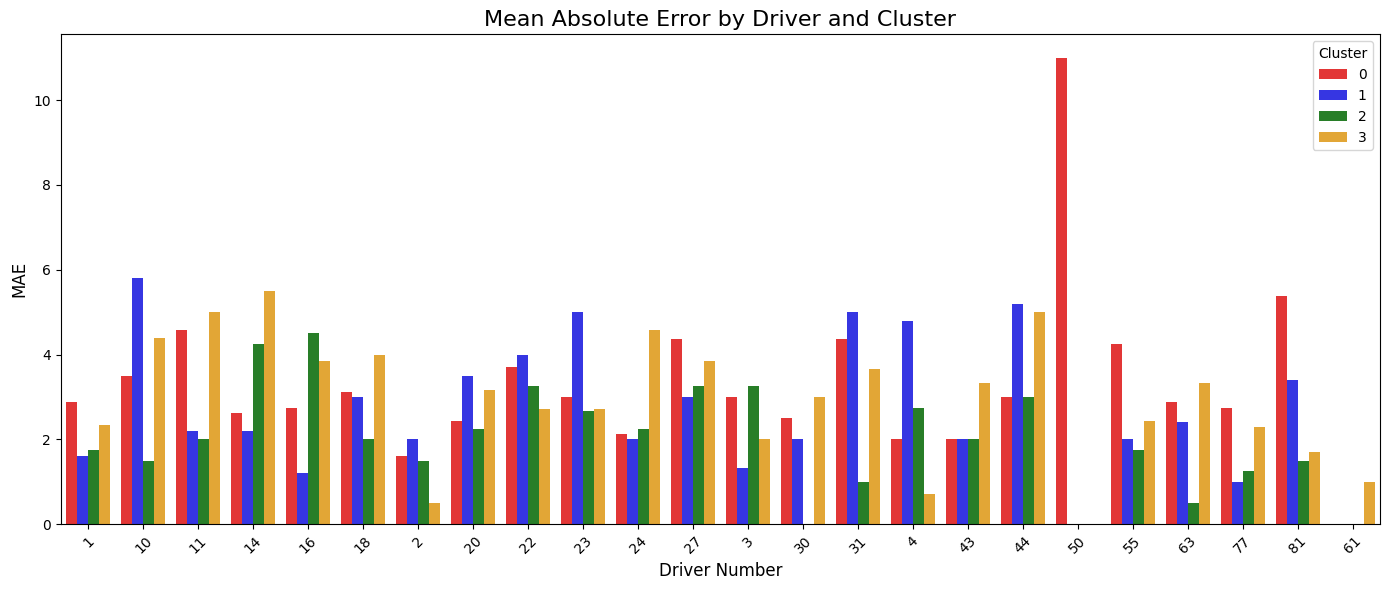

In [1302]:
plt.figure(figsize=(14, 6))

# Sort drivers by overall MAE (optional but helpful)
custom_palette = ['red', 'blue', 'green', 'orange']

sns.barplot(
    data=drivers_tracks,
    x='DriverNumber',
    y='MAE',
    hue='cluster',
    errorbar='sd',     # show variability
    alpha=0.9,
    palette=custom_palette
)

plt.title("Mean Absolute Error by Driver and Cluster", fontsize=16)
plt.xlabel("Driver Number", fontsize=12)
plt.ylabel("MAE", fontsize=12)

# Improve readability
plt.xticks(rotation=45)
plt.legend(title="Cluster")

plt.tight_layout()
plt.show()


<Axes: xlabel='cluster', ylabel='MAE'>

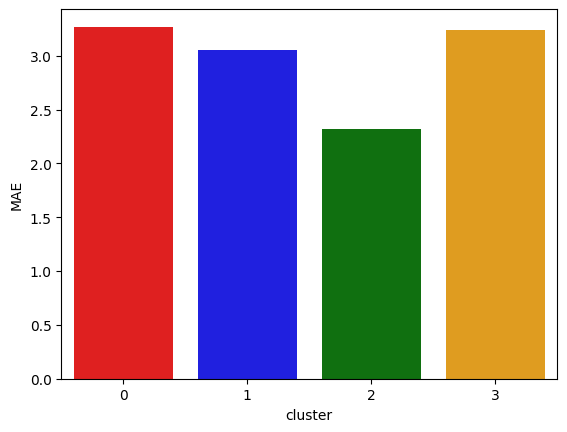

In [1303]:
sns.barplot(data=tracks, x='cluster', y='MAE', hue='cluster', palette=custom_palette, legend=None)

In [1304]:
tracks

,cluster,MAE
0,0,3.269231
1,1,3.052632
2,2,2.320513
3,3,3.238462
